In [1]:
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import torch
import torch.nn as nn
import time
import seaborn as sns
import math, time
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import gc
import plotly.io as pio

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
pio.renderers.default = "notebook_connected"
pd.options.mode.chained_assignment = None

## Download Dataset

In [2]:
TIINGO_KEY = "c5bed0ff936833e0e5366112479003dcd8449188"

dataset_df = pdr.get_data_tiingo('AAPL',start='December 12, 1980', api_key=TIINGO_KEY)
dataset_df.to_csv('AAPL.csv')

C:\Users\ROG\AppData\Roaming\Python\Python310\site-packages\pandas_datareader\tiingo.py:234: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.



In [3]:
dataset_df = pd.read_csv('AAPL.csv')

In [4]:
dataset_df

symbol                       date   close    high     low     open  \
0       AAPL  1980-12-12 00:00:00+00:00   28.75   28.87   28.75   28.750   
1       AAPL  1980-12-15 00:00:00+00:00   27.25   27.38   27.25   27.380   
2       AAPL  1980-12-16 00:00:00+00:00   25.25   25.37   25.25   25.370   
3       AAPL  1980-12-17 00:00:00+00:00   25.87   26.00   25.87   25.870   
4       AAPL  1980-12-18 00:00:00+00:00   26.63   26.75   26.63   26.630   
...      ...                        ...     ...     ...     ...      ...   
10818   AAPL  2023-11-13 00:00:00+00:00  184.80  186.03  184.21  185.820   
10819   AAPL  2023-11-14 00:00:00+00:00  187.44  188.11  186.30  187.700   
10820   AAPL  2023-11-15 00:00:00+00:00  188.01  189.50  187.78  187.845   
10821   AAPL  2023-11-16 00:00:00+00:00  189.71  190.96  188.65  189.570   
10822   AAPL  2023-11-17 00:00:00+00:00  189.69  190.38  188.57  190.250   

         volume    adjClose     adjHigh      adjLow     adjOpen  adjVolume  \
0       2093900    0.099568    0.099984    0.099568    0.099568  469034069   
1        785200    0.094373    0.094823    0.094373    0.094823  175884975   
2        472000    0.087447    0.087862    0.087447    0.087862  105728105   
3        385900    0.089594    0.090044    0.089594    0.089594   86441686   
4        327900    0.092226    0.092642    0.092226    0.092226   73449673   
...         ...         ...         ...         ...         ...        ...   
10818  43627519  184.800000  186.030000  184.210000  185.820000   43627519   
10819  60108378  187.440000  188.110000  186.300000  187.700000   60108378   
10820  53790499  188.010000  189.500000  187.780000  187.845000   53790499   
10821  54412915  189.710000  190.960000  188.650000  189.570000   54412915   
10822  50002825  189.690000  190.380000  188.570000  190.250000   50002825   

       divCash  splitFactor  
0          0.0          1.0  
1          0.0          1.0  
2          0.0          1.0  
3          0.0          1.0  
4          0.0          1.0  
...        ...          ...  
10818      0.0          1.0  
10819      0.0          1.0  
10820      0.0          1.0  
10821      0.0          1.0  
10822      0.0          1.0  

[10823 rows x 14 columns]

In [5]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10823 entries, 0 to 10822
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       10823 non-null  object 
 1   date         10823 non-null  object 
 2   close        10823 non-null  float64
 3   high         10823 non-null  float64
 4   low          10823 non-null  float64
 5   open         10823 non-null  float64
 6   volume       10823 non-null  int64  
 7   adjClose     10823 non-null  float64
 8   adjHigh      10823 non-null  float64
 9   adjLow       10823 non-null  float64
 10  adjOpen      10823 non-null  float64
 11  adjVolume    10823 non-null  int64  
 12  divCash      10823 non-null  float64
 13  splitFactor  10823 non-null  float64
dtypes: float64(10), int64(2), object(2)
memory usage: 1.2+ MB


## Cleaning Dataset

In [6]:
#removing the timestap
dataset_df['date'] = dataset_df['date'].str.split(' ').str[0]

dataset_df.head()

symbol        date  close   high    low   open   volume  adjClose   adjHigh  \
0   AAPL  1980-12-12  28.75  28.87  28.75  28.75  2093900  0.099568  0.099984   
1   AAPL  1980-12-15  27.25  27.38  27.25  27.38   785200  0.094373  0.094823   
2   AAPL  1980-12-16  25.25  25.37  25.25  25.37   472000  0.087447  0.087862   
3   AAPL  1980-12-17  25.87  26.00  25.87  25.87   385900  0.089594  0.090044   
4   AAPL  1980-12-18  26.63  26.75  26.63  26.63   327900  0.092226  0.092642   

     adjLow   adjOpen  adjVolume  divCash  splitFactor  
0  0.099568  0.099568  469034069      0.0          1.0  
1  0.094373  0.094823  175884975      0.0          1.0  
2  0.087447  0.087862  105728105      0.0          1.0  
3  0.089594  0.089594   86441686      0.0          1.0  
4  0.092226  0.092226   73449673      0.0          1.0

In [7]:
#resetting index and changing variable type
dataset_df = dataset_df.reset_index()[['date', 'adjClose']]
df_dates = dataset_df.iloc[:,0]
dataset_df['date'] = pd.to_datetime(dataset_df['date'])
dataset_df = dataset_df.set_index('date')
dataset_df.head()

adjClose
date                
1980-12-12  0.099568
1980-12-15  0.094373
1980-12-16  0.087447
1980-12-17  0.089594
1980-12-18  0.092226

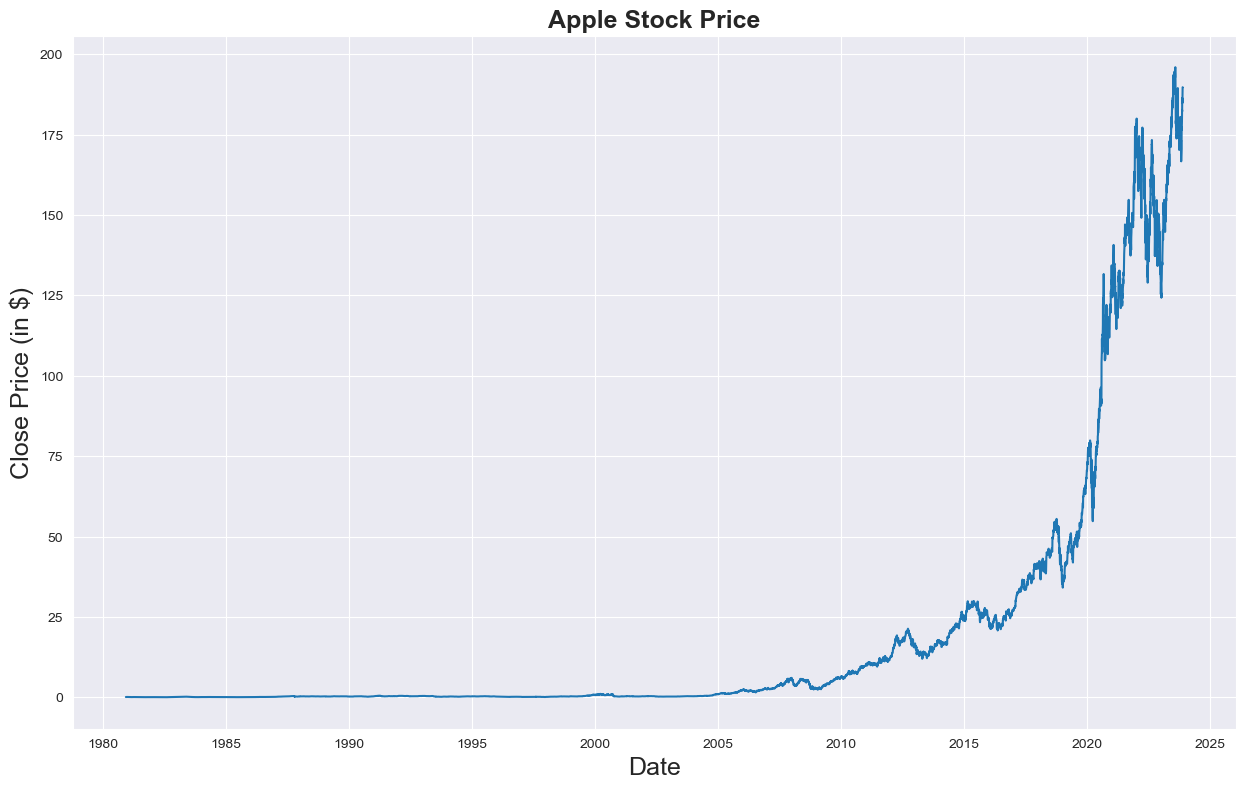

In [8]:
sns.set_style("darkgrid")
plt.figure(figsize = (15, 9))
plt.plot(dataset_df[['adjClose']])
plt.title("Apple Stock Price", fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price (in $)', fontsize=18)
plt.show()

In [9]:
#array of original prices data
dataset_df_prices = dataset_df['adjClose'].values.reshape(-1,1)

print(dataset_df_prices)

[[9.95681294e-02]
 [9.43732705e-02]
 [8.74467919e-02]
 ...
 [1.88010000e+02]
 [1.89710000e+02]
 [1.89690000e+02]]


In [10]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def torch_data(data, device):
    return to_device(torch.from_numpy(data).type(torch.Tensor), device)

device = get_default_device()
device

device(type='cpu')

## Preprocessing Dataset

In [11]:
def create_sequence(dataset, time_step):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step -1):
        a = dataset.iloc[i:(i + time_step)]
        dataX.append(a)
        dataY.append(dataset.iloc[i + time_step])
    return np.array(dataX), np.array(dataY)

In [12]:
def curate_dataset(dataset, time_step):
    train_size = round(len(dataset) * 0.80)
    remaining_size = len(dataset) - train_size
    val_size = round(0.50 * remaining_size)
    train_data, val_data, test_data = dataset.iloc[0:train_size, :], dataset.iloc[train_size:(train_size + val_size), :], dataset.iloc[(train_size + val_size):len(dataset), :]

    scaler = MinMaxScaler(feature_range = (0, 1))
    train_data['adjClose'] = scaler.fit_transform(np.array(train_data['adjClose']).reshape(-1, 1))
    val_data['adjClose'] = scaler.transform(np.array(val_data['adjClose']).reshape(-1, 1))
    test_data['adjClose'] = scaler.transform(np.array(test_data['adjClose']).reshape(-1, 1))

    X_train, y_train = create_sequence(train_data, time_step)
    X_val, y_val = create_sequence(val_data, time_step)
    X_test, y_test = create_sequence(test_data, time_step)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_val = y_val.reshape(y_val.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [13]:
def curate_dataset_test(dataset, time_step):
    train_size = round(len(dataset) * 0.90)
    train_data, test_data = dataset.iloc[0:train_size, :], dataset.iloc[train_size:, :]

    scaler = MinMaxScaler(feature_range = (0, 1))
    train_data['adjClose'] = scaler.fit_transform(np.array(train_data['adjClose']).reshape(-1, 1))
    test_data['adjClose'] = scaler.transform(np.array(test_data['adjClose']).reshape(-1, 1))

    X_train, y_train = create_sequence(train_data, time_step)
    X_test, y_test = create_sequence(test_data, time_step)

    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_test = y_test.reshape(y_test.shape[0], 1)

    return X_train, X_test, y_train, y_test, scaler

## Model Architecture (Vanilla RNN)

In [14]:
class RNN_base(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_base, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.layer_dim = layer_dim
        
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = 'tanh')
        
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=device))
            
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
def fit(num_epochs, lr, model, loss_type, opt_func, X_train, y_train):
    optimiser = opt_func(model.parameters(), lr)
    hist = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
        y_train_pred = model(X_train)
        loss = loss_type(y_train_pred, y_train)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()       

        optimiser.zero_grad()     

        loss.backward()
         
        optimiser.step()        
        
    training_time = time.time()-start_time
    print("T-time: {}\n".format(training_time))
    
    return hist, y_train_pred

In [16]:
def plot_loss(history):
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(8, 5))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax = sns.lineplot(data = history, color='royalblue')
    ax.set_xlabel("Epoch", size = 14)
    ax.set_ylabel("Loss", size = 14)
    ax.set_title("Training Loss", size = 14, fontweight='bold')

In [17]:
def plotly_predictions(results):
    fig = go.Figure()
    fig.add_trace(go.Scatter(go.Scatter(x=results['date'], y=results[0],
                        mode='lines',
                        name='Train prediction',
                        line = dict(color='#ff7f0e'))))
    fig.add_trace(go.Scatter(x=results['date'], y=results[1],
                        mode='lines',
                        name='Test prediction',
                        line = dict(color='#d62728')))
    fig.add_trace(go.Scatter(go.Scatter(x=results['date'], y=results[2],
                        opacity=0.6,
                        mode='lines',
                        name='Actual Value',
                        line = dict(color='#1f77b4'))))
    fig.update_layout(
        xaxis=dict(
            title_text='Dates',
            titlefont=dict(
                family='Rockwell',
                size=12,
                color='black',
            ),
            showline=True,
            showgrid=True,
            showticklabels=True,
            linecolor='black',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Rockwell',
                size=12,
                color='black',
            ),
        ),
        yaxis=dict(
            title_text='Close (USD)',
            titlefont=dict(
                family='Rockwell',
                size=12,
                color='black',
            ),
            showline=True,
            showgrid=True,
            showticklabels=True,
            linecolor='black',
            linewidth=2,
            ticks='outside',
            tickfont=dict(
                family='Rockwell',
                size=12,
                color='black',
            ),
        ),
        showlegend=True,
        template = 'plotly_white'

    )

    annotations = []
    annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                                xanchor='left', yanchor='bottom',
                                text='Results',
                                font=dict(family='Rockwell',
                                            size=26,
                                            color='black'),
                                showarrow=False))
    fig.update_layout(annotations=annotations)

    fig.show()

In [18]:
def evaluate_model_experiments(model, num_epochs, lr, loss_type, optimiser, time_step):
    X_train, X_val, X_test, y_train, y_val, y_test, scaler = curate_dataset(dataset_df, time_step)
    X_train = torch_data(X_train, device)
    X_val = torch_data(X_val, device)
    X_test = torch_data(X_test, device)
    y_train = torch_data(y_train, device) 
    y_val = torch_data(y_val, device)
    y_test = torch_data(y_test, device)

    history, y_train_pred = fit(num_epochs, lr, model, loss_type, optimiser, X_train, y_train)

    gc.collect()
    torch.cuda.empty_cache()

    y_val_pred = model(X_val)

    y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
    y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
    y_val_pred = scaler.inverse_transform(y_val_pred.cpu().detach().numpy())
    y_val = scaler.inverse_transform(y_val.cpu().detach().numpy())

    trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
    print("===========================")
    print('Train Score: %.2f RMSE' % (trainScore))
    print("===========================")
    valScore = math.sqrt(mean_squared_error(y_val, y_val_pred))
    print('Validation Score: %.2f RMSE' % (valScore))
    print("===========================")

    end_of_time = len(y_train_pred) + len(y_val_pred) + (time_step * 2) + 1

    trainPredictPlot = np.empty_like(dataset_df_prices[0 : end_of_time])
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step : len(y_train_pred) + time_step, :] = y_train_pred

    valPredictPlot = np.empty_like(dataset_df_prices[0 : end_of_time])
    valPredictPlot[:, :] = np.nan
    valPredictPlot[len(y_train_pred)  + (time_step * 2) + 1 : end_of_time, :] = y_val_pred
  
    original = dataset_df[0 : end_of_time]
    predictions = np.append(trainPredictPlot, valPredictPlot, axis=1)
    predictions = np.append(predictions, original, axis=1)
    result = pd.DataFrame(predictions)
    result = pd.concat([result, df_dates.iloc[0 : end_of_time]], axis = 1)

    metadata = [[time_step, model.layer_dim, model.hidden_dim, trainScore, valScore]]
    metadata = pd.DataFrame(metadata, columns=['time_step', 'num_layers', 'hidden_dim', 'trainScore', 'valScore'])   
        
    return metadata

In [19]:
def evaluate_single_model(model, num_epochs, lr, loss_type, optimiser, time_step):
    X_train, X_val, X_test, y_train, y_val, y_test, scaler = curate_dataset(dataset_df, time_step)
    X_train = torch_data(X_train, device)
    X_val = torch_data(X_val, device)
    X_test = torch_data(X_test, device)
    y_train = torch_data(y_train, device) 
    y_val = torch_data(y_val, device)
    y_test = torch_data(y_test, device)

    history, y_train_pred = fit(num_epochs, lr, model, loss_type, optimiser, X_train, y_train)

    gc.collect()
    torch.cuda.empty_cache()

    y_val_pred = model(X_val)

    y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
    y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
    y_val_pred = scaler.inverse_transform(y_val_pred.cpu().detach().numpy())
    y_val = scaler.inverse_transform(y_val.cpu().detach().numpy())

    trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
    print("===========================")
    print('Train Score: %.2f RMSE' % (trainScore))
    print("===========================")
    valScore = math.sqrt(mean_squared_error(y_val, y_val_pred))
    print('Validation Score: %.2f RMSE' % (valScore))
    print("===========================")

    end_of_time = len(y_train_pred) + len(y_val_pred) + (time_step * 2) + 1

    trainPredictPlot = np.empty_like(dataset_df_prices[0 : end_of_time])
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step : len(y_train_pred) + time_step, :] = y_train_pred

    valPredictPlot = np.empty_like(dataset_df_prices[0 : end_of_time])
    valPredictPlot[:, :] = np.nan
    valPredictPlot[len(y_train_pred)  + (time_step * 2) + 1 : end_of_time, :] = y_val_pred

    original = dataset_df[0 : end_of_time]    
    predictions = np.append(trainPredictPlot, valPredictPlot, axis=1)
    predictions = np.append(predictions, original, axis=1)
    result = pd.DataFrame(predictions)
    result = pd.concat([result, df_dates.iloc[0 : end_of_time]], axis = 1)
    plot_loss(history)
    plotly_predictions(result)    
    return None

In [20]:
def test_final_model(model, num_epochs, lr, loss_type, optimiser, time_step):
    X_train, X_test, y_train, y_test, scaler = curate_dataset_test(dataset_df, time_step)
    X_train = torch_data(X_train, device)
    X_test = torch_data(X_test, device)
    y_train = torch_data(y_train, device) 
    y_test = torch_data(y_test, device)

    history, y_train_pred = fit(num_epochs, lr, model, loss_type, optimiser, X_train, y_train)

    gc.collect()
    torch.cuda.empty_cache()

    y_test_pred = model(X_test)

    y_train_pred = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())
    y_train = scaler.inverse_transform(y_train.cpu().detach().numpy())
    y_test_pred = scaler.inverse_transform(y_test_pred.cpu().detach().numpy())
    y_test = scaler.inverse_transform(y_test.cpu().detach().numpy())

    trainScore = math.sqrt(mean_squared_error(y_train, y_train_pred))
    print("===========================")
    print('Train Score: %.2f RMSE' % (trainScore))
    print("===========================")
    testScore = math.sqrt(mean_squared_error(y_test, y_test_pred))
    print('Test Score: %.2f RMSE' % (testScore))
    print("===========================")

    end_of_time = len(y_train_pred) + len(y_test_pred) + (time_step * 2) + 1

    trainPredictPlot = np.empty_like(dataset_df_prices[0 : end_of_time])
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step : len(y_train_pred) + time_step, :] = y_train_pred

    testPredictPlot = np.empty_like(dataset_df_prices[0 : end_of_time])
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(y_train_pred)  + (time_step * 2) + 1 : end_of_time, :] = y_test_pred

    original = dataset_df[0 : end_of_time]    
    predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
    predictions = np.append(predictions, original, axis=1)
    result = pd.DataFrame(predictions)
    result = pd.concat([result, df_dates.iloc[0 : end_of_time]], axis = 1)
    plot_loss(history)
    plotly_predictions(result)    
    return None

## Vanilla RNN

In [21]:
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam
time_step = 20

torch.manual_seed(42)
vanilla_rnn = RNN_base(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
vanilla_rnn = to_device(vanilla_rnn, device)



## Model Architecture (Vanilla RNN with ReLU)

In [22]:
class RNN_relu(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_relu, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.layer_dim = layer_dim
        
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first = True, nonlinearity = 'relu')
        
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=device))
            
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

## Vanilla RNN with ReLU

Epoch  0 MSE:  0.8626009821891785
Epoch  1 MSE:  0.6538116931915283
Epoch  2 MSE:  0.4951014816761017
Epoch  3 MSE:  0.3755500018596649
Epoch  4 MSE:  0.2861906588077545
Epoch  5 MSE:  0.21986396610736847
Epoch  6 MSE:  0.17097650468349457
Epoch  7 MSE:  0.13522690534591675
Epoch  8 MSE:  0.1093410849571228
Epoch  9 MSE:  0.09084150195121765
Epoch  10 MSE:  0.07785815000534058
Epoch  11 MSE:  0.06897977739572525
Epoch  12 MSE:  0.0631399005651474
Epoch  13 MSE:  0.05953085795044899
Epoch  14 MSE:  0.057539667934179306
Epoch  15 MSE:  0.056700270622968674
Epoch  16 MSE:  0.05665802210569382
Epoch  17 MSE:  0.05714334174990654
Epoch  18 MSE:  0.057951975613832474
Epoch  19 MSE:  0.05893015116453171
Epoch  20 MSE:  0.05996333435177803
Epoch  21 MSE:  0.06096770614385605
Epoch  22 MSE:  0.06188347190618515
Epoch  23 MSE:  0.06266980618238449
Epoch  24 MSE:  0.06330068409442902
Epoch  25 MSE:  0.06376182287931442
Epoch  26 MSE:  0.06404796987771988
Epoch  27 MSE:  0.06416090577840805
Epoch 

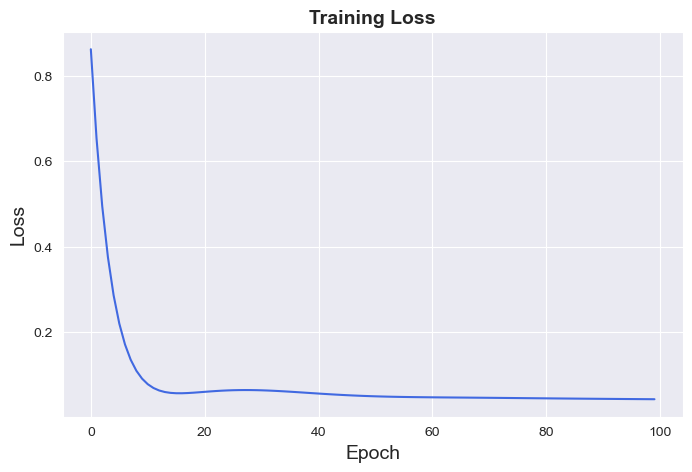

In [23]:
input_dim = 1
hidden_dim = 1
num_layers = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam
time_step = 20

torch.manual_seed(42)
relu_rnn = RNN_relu(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
relu_rnn = to_device(relu_rnn, device)

evaluate_single_model(relu_rnn, num_epochs, lr, loss_type, optimiser, time_step)

## Hyperparameters Tuning

In [24]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam

num_layers = [1, 2]
sliding_windows = [20, 30, 50, 100]
hidden_dims = [2, 4, 8, 16, 32]

tanh_results = []
relu_results = []
for time_step in sliding_windows:
    for hidden_dim in hidden_dims:
        for layers in num_layers:

            print("====================================================")
            print("Time Step =", time_step, "| Hidden States =", hidden_dim, "| Num Layers =", layers)
            print("====================================================")
            print()

            torch.manual_seed(42)
            tanh_rnn = RNN_base(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = layers)
            tanh_rnn = to_device(tanh_rnn, device)
                                 
            tanh_res = evaluate_model_experiments(tanh_rnn, num_epochs, lr, loss_type, optimiser, time_step)
            tanh_results += [tanh_res.iloc[0]]
            print()

            torch.manual_seed(42)
            relu_rnn_exp = RNN_relu(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = layers)
            relu_rnn_exp = to_device(relu_rnn_exp, device)
            relu_res = evaluate_model_experiments(relu_rnn_exp, num_epochs, lr, loss_type, optimiser, time_step)
            relu_results += [relu_res.iloc[0]]
            print()

Time Step = 20 | Hidden States = 2 | Num Layers = 1

Epoch  0 MSE:  0.3117377460002899
Epoch  1 MSE:  0.2746148705482483
Epoch  2 MSE:  0.24029582738876343
Epoch  3 MSE:  0.2088046669960022
Epoch  4 MSE:  0.18011356890201569
Epoch  5 MSE:  0.15414702892303467
Epoch  6 MSE:  0.13079072535037994
Epoch  7 MSE:  0.10990475863218307
Epoch  8 MSE:  0.09133993089199066
Epoch  9 MSE:  0.07495430111885071
Epoch  10 MSE:  0.06062619760632515
Epoch  11 MSE:  0.0482601523399353
Epoch  12 MSE:  0.03778504580259323
Epoch  13 MSE:  0.029145292937755585
Epoch  14 MSE:  0.022287432104349136
Epoch  15 MSE:  0.017145032063126564
Epoch  16 MSE:  0.013624034821987152
Epoch  17 MSE:  0.011590245179831982
Epoch  18 MSE:  0.010860525071620941
Epoch  19 MSE:  0.011199633590877056
Epoch  20 MSE:  0.012325135990977287
Epoch  21 MSE:  0.013922504149377346
Epoch  22 MSE:  0.01567043736577034
Epoch  23 MSE:  0.017272917553782463
Epoch  24 MSE:  0.018491139635443687
Epoch  25 MSE:  0.019167141988873482
Epoch  26 MSE

Epoch  8 MSE:  0.07859832048416138
Epoch  9 MSE:  0.061599843204021454
Epoch  10 MSE:  0.04789050295948982
Epoch  11 MSE:  0.037643350660800934
Epoch  12 MSE:  0.03089490532875061
Epoch  13 MSE:  0.027493031695485115
Epoch  14 MSE:  0.027059728279709816
Epoch  15 MSE:  0.028982290998101234
Epoch  16 MSE:  0.03245070204138756
Epoch  17 MSE:  0.036555781960487366
Epoch  18 MSE:  0.04043719545006752
Epoch  19 MSE:  0.0434299036860466
Epoch  20 MSE:  0.04514726623892784
Epoch  21 MSE:  0.04548101872205734
Epoch  22 MSE:  0.04454479366540909
Epoch  23 MSE:  0.04259803518652916
Epoch  24 MSE:  0.039973512291908264
Epoch  25 MSE:  0.037017956376075745
Epoch  26 MSE:  0.034047406166791916
Epoch  27 MSE:  0.03131736069917679
Epoch  28 MSE:  0.029006430879235268
Epoch  29 MSE:  0.027212565764784813
Epoch  30 MSE:  0.025959370657801628
Epoch  31 MSE:  0.02520977519452572
Epoch  32 MSE:  0.02488354966044426
Epoch  33 MSE:  0.024875450879335403
Epoch  34 MSE:  0.02507156692445278
Epoch  35 MSE:  0.

Epoch  23 MSE:  0.03214031085371971
Epoch  24 MSE:  0.03050883300602436
Epoch  25 MSE:  0.028900932520627975
Epoch  26 MSE:  0.027420081198215485
Epoch  27 MSE:  0.026128524914383888
Epoch  28 MSE:  0.02503422647714615
Epoch  29 MSE:  0.02409137226641178
Epoch  30 MSE:  0.023216255009174347
Epoch  31 MSE:  0.022315163165330887
Epoch  32 MSE:  0.02131510339677334
Epoch  33 MSE:  0.020185701549053192
Epoch  34 MSE:  0.018944963812828064
Epoch  35 MSE:  0.017648566514253616
Epoch  36 MSE:  0.01636810041964054
Epoch  37 MSE:  0.015165803954005241
Epoch  38 MSE:  0.014073267579078674
Epoch  39 MSE:  0.013080640695989132
Epoch  40 MSE:  0.01214095763862133
Epoch  41 MSE:  0.011190218850970268
Epoch  42 MSE:  0.010176819749176502
Epoch  43 MSE:  0.009087163023650646
Epoch  44 MSE:  0.007953930646181107
Epoch  45 MSE:  0.00684200506657362
Epoch  46 MSE:  0.005818046163767576
Epoch  47 MSE:  0.004917980637401342
Epoch  48 MSE:  0.004130267072468996
Epoch  49 MSE:  0.003408480668440461
Epoch  50

Epoch  35 MSE:  0.002068799454718828
Epoch  36 MSE:  0.0019051248673349619
Epoch  37 MSE:  0.0014304250944405794
Epoch  38 MSE:  0.0008804212557151914
Epoch  39 MSE:  0.0004819741006940603
Epoch  40 MSE:  0.0003506467037368566
Epoch  41 MSE:  0.00045837441575713456
Epoch  42 MSE:  0.0006739501841366291
Epoch  43 MSE:  0.0008444260456599295
Epoch  44 MSE:  0.0008712830021977425
Epoch  45 MSE:  0.0007461814093403518
Epoch  46 MSE:  0.0005373554886318743
Epoch  47 MSE:  0.00034283226705156267
Epoch  48 MSE:  0.00023875865736044943
Epoch  49 MSE:  0.0002476582885719836
Epoch  50 MSE:  0.00033742657979018986
Epoch  51 MSE:  0.00044567236909642816
Epoch  52 MSE:  0.0005134740495122969
Epoch  53 MSE:  0.0005114704254083335
Epoch  54 MSE:  0.00044796260772272944
Epoch  55 MSE:  0.00035851928987540305
Epoch  56 MSE:  0.00028476741863414645
Epoch  57 MSE:  0.0002536349056754261
Epoch  58 MSE:  0.0002666363143362105
Epoch  59 MSE:  0.0003030527732335031
Epoch  60 MSE:  0.00033376243663951755
Epoc

Epoch  46 MSE:  0.00020845689869020134
Epoch  47 MSE:  0.0002831336169037968
Epoch  48 MSE:  0.00026966514997184277
Epoch  49 MSE:  0.0001951527374330908
Epoch  50 MSE:  0.00015049483045004308
Epoch  51 MSE:  0.0001524468680145219
Epoch  52 MSE:  0.00014250243839342147
Epoch  53 MSE:  9.658630006015301e-05
Epoch  54 MSE:  5.795023389509879e-05
Epoch  55 MSE:  6.263986142585054e-05
Epoch  56 MSE:  9.076762944459915e-05
Epoch  57 MSE:  0.00010361338354414329
Epoch  58 MSE:  9.526342182653025e-05
Epoch  59 MSE:  8.93671385711059e-05
Epoch  60 MSE:  9.86564700724557e-05
Epoch  61 MSE:  0.00010784040932776406
Epoch  62 MSE:  9.89845793810673e-05
Epoch  63 MSE:  7.800159801263362e-05
Epoch  64 MSE:  6.446017505368218e-05
Epoch  65 MSE:  6.379968544933945e-05
Epoch  66 MSE:  6.37236880720593e-05
Epoch  67 MSE:  5.624253390124068e-05
Epoch  68 MSE:  4.9524711357662454e-05
Epoch  69 MSE:  5.300314660416916e-05
Epoch  70 MSE:  6.14994132774882e-05
Epoch  71 MSE:  6.373723590513691e-05
Epoch  72 

Epoch  54 MSE:  0.00018226038082502782
Epoch  55 MSE:  0.000157597751240246
Epoch  56 MSE:  0.00014848430873826146
Epoch  57 MSE:  0.00017917758668772876
Epoch  58 MSE:  0.000199176836758852
Epoch  59 MSE:  0.00018203664512839168
Epoch  60 MSE:  0.00016696045349817723
Epoch  61 MSE:  0.00016738651902414858
Epoch  62 MSE:  0.00015301025996450335
Epoch  63 MSE:  0.00012692069867625833
Epoch  64 MSE:  0.00012079757289029658
Epoch  65 MSE:  0.00013021094491705298
Epoch  66 MSE:  0.00013026606757193804
Epoch  67 MSE:  0.00012582792260218412
Epoch  68 MSE:  0.000131158041767776
Epoch  69 MSE:  0.00013500383647624403
Epoch  70 MSE:  0.0001255514071090147
Epoch  71 MSE:  0.0001149943855125457
Epoch  72 MSE:  0.00011284036736469716
Epoch  73 MSE:  0.00010969607683364302
Epoch  74 MSE:  0.0001028960250550881
Epoch  75 MSE:  0.00010250233754049987
Epoch  76 MSE:  0.0001069468489731662
Epoch  77 MSE:  0.00010627409938024357
Epoch  78 MSE:  0.00010303071030648425
Epoch  79 MSE:  0.00010282260336680

Epoch  62 MSE:  9.562201739754528e-05
Epoch  63 MSE:  7.57636662456207e-05
Epoch  64 MSE:  7.908885891083628e-05
Epoch  65 MSE:  9.280514495912939e-05
Epoch  66 MSE:  9.375505760544911e-05
Epoch  67 MSE:  7.628395542269573e-05
Epoch  68 MSE:  5.672995757777244e-05
Epoch  69 MSE:  5.243369014351629e-05
Epoch  70 MSE:  6.205546378623694e-05
Epoch  71 MSE:  6.978850433370098e-05
Epoch  72 MSE:  6.582881906069815e-05
Epoch  73 MSE:  5.670761311193928e-05
Epoch  74 MSE:  5.429984230431728e-05
Epoch  75 MSE:  6.001130532240495e-05
Epoch  76 MSE:  6.446158658945933e-05
Epoch  77 MSE:  6.0751444834750146e-05
Epoch  78 MSE:  5.26848052686546e-05
Epoch  79 MSE:  4.850115146837197e-05
Epoch  80 MSE:  5.025079371989705e-05
Epoch  81 MSE:  5.265421714284457e-05
Epoch  82 MSE:  5.11282923980616e-05
Epoch  83 MSE:  4.7349745727842674e-05
Epoch  84 MSE:  4.5909429900348186e-05
Epoch  85 MSE:  4.7882327635306865e-05
Epoch  86 MSE:  4.9921971367439255e-05
Epoch  87 MSE:  4.907139373244718e-05
Epoch  88 

Epoch  68 MSE:  0.00022449909010902047
Epoch  69 MSE:  0.00020683534967247397
Epoch  70 MSE:  0.0001851048436947167
Epoch  71 MSE:  0.00018543635087553412
Epoch  72 MSE:  0.00018371152691543102
Epoch  73 MSE:  0.0001696461986284703
Epoch  74 MSE:  0.00016879275790415704
Epoch  75 MSE:  0.000178822097950615
Epoch  76 MSE:  0.00017477790242992342
Epoch  77 MSE:  0.0001649100158829242
Epoch  78 MSE:  0.00016467231034766883
Epoch  79 MSE:  0.0001615305955056101
Epoch  80 MSE:  0.00015122946933843195
Epoch  81 MSE:  0.00014862215903121978
Epoch  82 MSE:  0.00015189674741122872
Epoch  83 MSE:  0.00014921993715688586
Epoch  84 MSE:  0.00014545302838087082
Epoch  85 MSE:  0.00014611586811952293
Epoch  86 MSE:  0.0001436998718418181
Epoch  87 MSE:  0.0001373736304230988
Epoch  88 MSE:  0.00013497019244823605
Epoch  89 MSE:  0.00013471097918227315
Epoch  90 MSE:  0.00013174832565709949
Epoch  91 MSE:  0.0001299875002587214
Epoch  92 MSE:  0.00013042658974882215
Epoch  93 MSE:  0.0001282255543628

Epoch  73 MSE:  3.229409776395187e-05
Epoch  74 MSE:  3.4605363907758147e-05
Epoch  75 MSE:  3.221450970158912e-05
Epoch  76 MSE:  3.057930007344112e-05
Epoch  77 MSE:  3.207412373740226e-05
Epoch  78 MSE:  3.204312815796584e-05
Epoch  79 MSE:  2.9541310141212307e-05
Epoch  80 MSE:  2.896751175285317e-05
Epoch  81 MSE:  3.072859180974774e-05
Epoch  82 MSE:  3.1001869501778856e-05
Epoch  83 MSE:  2.9598399123642594e-05
Epoch  84 MSE:  2.9389968403847888e-05
Epoch  85 MSE:  3.0049000997678377e-05
Epoch  86 MSE:  2.9412749427137896e-05
Epoch  87 MSE:  2.8373455279506743e-05
Epoch  88 MSE:  2.8746499083354138e-05
Epoch  89 MSE:  2.9423608793877065e-05
Epoch  90 MSE:  2.8964299417566508e-05
Epoch  91 MSE:  2.842502908606548e-05
Epoch  92 MSE:  2.8664655474130996e-05
Epoch  93 MSE:  2.8654159905272536e-05
Epoch  94 MSE:  2.8076836315449327e-05
Epoch  95 MSE:  2.7970267183263786e-05
Epoch  96 MSE:  2.8341697543510236e-05
Epoch  97 MSE:  2.8267773814150132e-05
Epoch  98 MSE:  2.789832615235354

Epoch  77 MSE:  8.632185199530795e-05
Epoch  78 MSE:  8.673310367157683e-05
Epoch  79 MSE:  8.063855057116598e-05
Epoch  80 MSE:  7.733948586974293e-05
Epoch  81 MSE:  7.81349663157016e-05
Epoch  82 MSE:  7.639620889676735e-05
Epoch  83 MSE:  7.239690603455529e-05
Epoch  84 MSE:  7.219724648166448e-05
Epoch  85 MSE:  7.47850863263011e-05
Epoch  86 MSE:  7.426457887049764e-05
Epoch  87 MSE:  7.111026934580877e-05
Epoch  88 MSE:  6.985195796005428e-05
Epoch  89 MSE:  6.990742986090481e-05
Epoch  90 MSE:  6.824899173807353e-05
Epoch  91 MSE:  6.633659359067678e-05
Epoch  92 MSE:  6.662202213192359e-05
Epoch  93 MSE:  6.730416498612612e-05
Epoch  94 MSE:  6.616158498218283e-05
Epoch  95 MSE:  6.461789598688483e-05
Epoch  96 MSE:  6.420546560548246e-05
Epoch  97 MSE:  6.368995673255995e-05
Epoch  98 MSE:  6.23539017396979e-05
Epoch  99 MSE:  6.16145262029022e-05
T-time: 15.115833759307861

Train Score: 0.23 RMSE
Validation Score: 6.11 RMSE

Epoch  0 MSE:  0.08024495095014572
Epoch  1 MSE:  

Epoch  86 MSE:  9.51367401285097e-05
Epoch  87 MSE:  8.65132751641795e-05
Epoch  88 MSE:  7.955395267345011e-05
Epoch  89 MSE:  7.447881944244727e-05
Epoch  90 MSE:  7.114611798897386e-05
Epoch  91 MSE:  6.914885307196528e-05
Epoch  92 MSE:  6.793917418690398e-05
Epoch  93 MSE:  6.695430784020573e-05
Epoch  94 MSE:  6.572438724106178e-05
Epoch  95 MSE:  6.394410593202338e-05
Epoch  96 MSE:  6.150191620690748e-05
Epoch  97 MSE:  5.8470290241530165e-05
Epoch  98 MSE:  5.5061984312487766e-05
Epoch  99 MSE:  5.1569331844802946e-05
T-time: 3.420062780380249

Train Score: 0.21 RMSE
Validation Score: 7.22 RMSE

Epoch  0 MSE:  0.38266265392303467
Epoch  1 MSE:  0.35195863246917725
Epoch  2 MSE:  0.32383808493614197
Epoch  3 MSE:  0.2980961501598358
Epoch  4 MSE:  0.27448973059654236
Epoch  5 MSE:  0.2528187036514282
Epoch  6 MSE:  0.23289845883846283
Epoch  7 MSE:  0.214585542678833
Epoch  8 MSE:  0.19774752855300903
Epoch  9 MSE:  0.18226271867752075
Epoch  10 MSE:  0.16802451014518738
Epoch 

Epoch  98 MSE:  0.002561075845733285
Epoch  99 MSE:  0.0025013568811118603
T-time: 5.778496265411377

Train Score: 1.49 RMSE
Validation Score: 18.77 RMSE

Epoch  0 MSE:  0.29807865619659424
Epoch  1 MSE:  0.2621855139732361
Epoch  2 MSE:  0.22666998207569122
Epoch  3 MSE:  0.1917477548122406
Epoch  4 MSE:  0.15778708457946777
Epoch  5 MSE:  0.12516888976097107
Epoch  6 MSE:  0.09433102607727051
Epoch  7 MSE:  0.06483282148838043
Epoch  8 MSE:  0.038022931665182114
Epoch  9 MSE:  0.01695605181157589
Epoch  10 MSE:  0.0038654657546430826
Epoch  11 MSE:  0.0014090311015024781
Epoch  12 MSE:  0.010699622333049774
Epoch  13 MSE:  0.02510492503643036
Epoch  14 MSE:  0.03396249935030937
Epoch  15 MSE:  0.03449345752596855
Epoch  16 MSE:  0.02924114465713501
Epoch  17 MSE:  0.02175324410200119
Epoch  18 MSE:  0.014597320929169655
Epoch  19 MSE:  0.009082449600100517
Epoch  20 MSE:  0.005619177594780922
Epoch  21 MSE:  0.004042669665068388
Epoch  22 MSE:  0.003924746997654438
Epoch  23 MSE:  0.

Epoch  0 MSE:  0.11873690038919449
Epoch  1 MSE:  0.10858886688947678
Epoch  2 MSE:  0.09937623888254166
Epoch  3 MSE:  0.09090328961610794
Epoch  4 MSE:  0.0831817016005516
Epoch  5 MSE:  0.07625410705804825
Epoch  6 MSE:  0.07018733769655228
Epoch  7 MSE:  0.06499002128839493
Epoch  8 MSE:  0.06072250381112099
Epoch  9 MSE:  0.05742676928639412
Epoch  10 MSE:  0.055086709558963776
Epoch  11 MSE:  0.05356884002685547
Epoch  12 MSE:  0.052618417888879776
Epoch  13 MSE:  0.05197449028491974
Epoch  14 MSE:  0.05144820734858513
Epoch  15 MSE:  0.050918083637952805
Epoch  16 MSE:  0.05031367763876915
Epoch  17 MSE:  0.04960484802722931
Epoch  18 MSE:  0.048792384564876556
Epoch  19 MSE:  0.047898441553115845
Epoch  20 MSE:  0.04695729538798332
Epoch  21 MSE:  0.04600735381245613
Epoch  22 MSE:  0.0450848750770092
Epoch  23 MSE:  0.04421991854906082
Epoch  24 MSE:  0.04343396797776222
Epoch  25 MSE:  0.04273933917284012
Epoch  26 MSE:  0.04213965684175491
Epoch  27 MSE:  0.04163121804594993

Epoch  10 MSE:  0.02477172389626503
Epoch  11 MSE:  0.018667301163077354
Epoch  12 MSE:  0.013977711088955402
Epoch  13 MSE:  0.010358172468841076
Epoch  14 MSE:  0.007532702758908272
Epoch  15 MSE:  0.005553756840527058
Epoch  16 MSE:  0.0035986308939754963
Epoch  17 MSE:  0.0018780081300064921
Epoch  18 MSE:  0.000937403179705143
Epoch  19 MSE:  0.0009102059993892908
Epoch  20 MSE:  0.0012762368423864245
Epoch  21 MSE:  0.0013515419559553266
Epoch  22 MSE:  0.0012593321735039353
Epoch  23 MSE:  0.0013216034276410937
Epoch  24 MSE:  0.00163002940826118
Epoch  25 MSE:  0.002029021503403783
Epoch  26 MSE:  0.00222956296056509
Epoch  27 MSE:  0.002087288536131382
Epoch  28 MSE:  0.001662412192672491
Epoch  29 MSE:  0.0011413426836952567
Epoch  30 MSE:  0.0007166664581745863
Epoch  31 MSE:  0.0004806744691450149
Epoch  32 MSE:  0.000422908051405102
Epoch  33 MSE:  0.00042321704677306116
Epoch  34 MSE:  0.0003457537095528096
Epoch  35 MSE:  0.00022183200053405017
Epoch  36 MSE:  0.00016717

Epoch  17 MSE:  0.013293270952999592
Epoch  18 MSE:  0.012063956819474697
Epoch  19 MSE:  0.010787257924675941
Epoch  20 MSE:  0.009486738592386246
Epoch  21 MSE:  0.008209380321204662
Epoch  22 MSE:  0.006960908882319927
Epoch  23 MSE:  0.005715483333915472
Epoch  24 MSE:  0.0044549135491251945
Epoch  25 MSE:  0.003249770263209939
Epoch  26 MSE:  0.0022121246438473463
Epoch  27 MSE:  0.001395604689605534
Epoch  28 MSE:  0.0007670857012271881
Epoch  29 MSE:  0.0003895141708198935
Epoch  30 MSE:  0.0004035530728287995
Epoch  31 MSE:  0.0006746084545738995
Epoch  32 MSE:  0.0011361748911440372
Epoch  33 MSE:  0.0016898877220228314
Epoch  34 MSE:  0.0019877550657838583
Epoch  35 MSE:  0.0020919612143188715
Epoch  36 MSE:  0.0018833709182217717
Epoch  37 MSE:  0.0015440450515598059
Epoch  38 MSE:  0.0011663420591503382
Epoch  39 MSE:  0.0007990178419277072
Epoch  40 MSE:  0.0005547424079850316
Epoch  41 MSE:  0.00039213517447933555
Epoch  42 MSE:  0.00031762433354742825
Epoch  43 MSE:  0.0

Epoch  22 MSE:  0.0030199741013348103
Epoch  23 MSE:  0.002545987954363227
Epoch  24 MSE:  0.0017130895284935832
Epoch  25 MSE:  0.001369559089653194
Epoch  26 MSE:  0.001118310377933085
Epoch  27 MSE:  0.0016328484052792192
Epoch  28 MSE:  0.0019065128872171044
Epoch  29 MSE:  0.001991968834772706
Epoch  30 MSE:  0.0018296599155291915
Epoch  31 MSE:  0.0013502661604434252
Epoch  32 MSE:  0.0011078735115006566
Epoch  33 MSE:  0.0008505926234647632
Epoch  34 MSE:  0.0009283379768021405
Epoch  35 MSE:  0.0010610708268359303
Epoch  36 MSE:  0.0011206634808331728
Epoch  37 MSE:  0.0010916629107668996
Epoch  38 MSE:  0.0008628190262243152
Epoch  39 MSE:  0.0007309984066523612
Epoch  40 MSE:  0.0005632570246234536
Epoch  41 MSE:  0.0005737202591262758
Epoch  42 MSE:  0.0005830045556649566
Epoch  43 MSE:  0.000628706649877131
Epoch  44 MSE:  0.0006435530376620591
Epoch  45 MSE:  0.0005891544278711081
Epoch  46 MSE:  0.0005501447012647986
Epoch  47 MSE:  0.00045637256698682904
Epoch  48 MSE:  

Epoch  29 MSE:  0.001109876437112689
Epoch  30 MSE:  0.0011286423541605473
Epoch  31 MSE:  0.0011711844708770514
Epoch  32 MSE:  0.0010610781610012054
Epoch  33 MSE:  0.0008542826399207115
Epoch  34 MSE:  0.0007018379401415586
Epoch  35 MSE:  0.0006668834248557687
Epoch  36 MSE:  0.0007031720597296953
Epoch  37 MSE:  0.0007260054117068648
Epoch  38 MSE:  0.0006805112352594733
Epoch  39 MSE:  0.0005828909925185144
Epoch  40 MSE:  0.0004793155239894986
Epoch  41 MSE:  0.00039136980194598436
Epoch  42 MSE:  0.00033165502827614546
Epoch  43 MSE:  0.0002828448486980051
Epoch  44 MSE:  0.00022590119624510407
Epoch  45 MSE:  0.00016700786363799125
Epoch  46 MSE:  0.00013159227091819048
Epoch  47 MSE:  0.00013282072904985398
Epoch  48 MSE:  0.00015328962763305753
Epoch  49 MSE:  0.00015745572454761714
Epoch  50 MSE:  0.00013294436212163419
Epoch  51 MSE:  0.00010373975965194404
Epoch  52 MSE:  9.544124623062089e-05
Epoch  53 MSE:  0.00010089040733873844
Epoch  54 MSE:  9.908053471008316e-05
Ep

Epoch  33 MSE:  0.00043419579742476344
Epoch  34 MSE:  0.00038480141665786505
Epoch  35 MSE:  0.0005942038842476904
Epoch  36 MSE:  0.0006243662792257965
Epoch  37 MSE:  0.0005102031282149255
Epoch  38 MSE:  0.0005328659317456186
Epoch  39 MSE:  0.0006228481070138514
Epoch  40 MSE:  0.0005523687577806413
Epoch  41 MSE:  0.0003279162338003516
Epoch  42 MSE:  0.000254482205491513
Epoch  43 MSE:  0.0004491614527069032
Epoch  44 MSE:  0.0003988945099990815
Epoch  45 MSE:  0.0002906854497268796
Epoch  46 MSE:  0.00039125443436205387
Epoch  47 MSE:  0.00043944932986050844
Epoch  48 MSE:  0.0002942840219475329
Epoch  49 MSE:  0.00020787429821211845
Epoch  50 MSE:  0.0002661723119672388
Epoch  51 MSE:  0.00023390684509649873
Epoch  52 MSE:  0.00015311651804950088
Epoch  53 MSE:  0.00020498853700701147
Epoch  54 MSE:  0.00024728922289796174
Epoch  55 MSE:  0.00018020212883129716
Epoch  56 MSE:  0.0001582519616931677
Epoch  57 MSE:  0.00018766222638078034
Epoch  58 MSE:  0.00014601738075725734
E

Epoch  37 MSE:  0.0003980014007538557
Epoch  38 MSE:  0.00044235336827114224
Epoch  39 MSE:  0.00039810093585401773
Epoch  40 MSE:  0.0003637470945250243
Epoch  41 MSE:  0.0002727460814639926
Epoch  42 MSE:  0.00013942648365627974
Epoch  43 MSE:  0.00010942869266727939
Epoch  44 MSE:  0.00015030332724563777
Epoch  45 MSE:  0.00016952621808741242
Epoch  46 MSE:  0.00021233675943221897
Epoch  47 MSE:  0.00022135199105832726
Epoch  48 MSE:  0.0001490727299824357
Epoch  49 MSE:  0.00010267207835568115
Epoch  50 MSE:  8.47571573103778e-05
Epoch  51 MSE:  7.083558011800051e-05
Epoch  52 MSE:  9.883721941150725e-05
Epoch  53 MSE:  0.0001286415645154193
Epoch  54 MSE:  0.00012023618910461664
Epoch  55 MSE:  0.00010710935021052137
Epoch  56 MSE:  8.736267773201689e-05
Epoch  57 MSE:  5.6622186093591154e-05
Epoch  58 MSE:  5.462953413370997e-05
Epoch  59 MSE:  6.734654016327113e-05
Epoch  60 MSE:  7.255403033923358e-05
Epoch  61 MSE:  8.22818255983293e-05
Epoch  62 MSE:  7.443981303367764e-05
Ep

Epoch  41 MSE:  0.00014247219951357692
Epoch  42 MSE:  0.0004337899445090443
Epoch  43 MSE:  0.000349457492120564
Epoch  44 MSE:  0.0001060503491316922
Epoch  45 MSE:  0.0001747085334500298
Epoch  46 MSE:  0.0003238439094275236
Epoch  47 MSE:  0.0002457944501657039
Epoch  48 MSE:  8.178892312571406e-05
Epoch  49 MSE:  0.00011869287845911458
Epoch  50 MSE:  0.00024003033468034118
Epoch  51 MSE:  0.00016651426267344505
Epoch  52 MSE:  7.306098996195942e-05
Epoch  53 MSE:  0.00012503174366429448
Epoch  54 MSE:  0.00017768134421203285
Epoch  55 MSE:  0.00012896090629510581
Epoch  56 MSE:  6.268874130910262e-05
Epoch  57 MSE:  8.841182716423646e-05
Epoch  58 MSE:  0.0001338555885013193
Epoch  59 MSE:  9.413640509592369e-05
Epoch  60 MSE:  5.910187610425055e-05
Epoch  61 MSE:  8.58085259096697e-05
Epoch  62 MSE:  0.00010465980449225754
Epoch  63 MSE:  7.666425517527387e-05
Epoch  64 MSE:  5.294810398481786e-05
Epoch  65 MSE:  7.063599332468584e-05
Epoch  66 MSE:  8.35168466437608e-05
Epoch  

Epoch  49 MSE:  0.01634795404970646
Epoch  50 MSE:  0.015054458752274513
Epoch  51 MSE:  0.013852948322892189
Epoch  52 MSE:  0.012752470560371876
Epoch  53 MSE:  0.011765259318053722
Epoch  54 MSE:  0.010898460634052753
Epoch  55 MSE:  0.010146119631826878
Epoch  56 MSE:  0.009485051035881042
Epoch  57 MSE:  0.008878364227712154
Epoch  58 MSE:  0.008290158584713936
Epoch  59 MSE:  0.007703706622123718
Epoch  60 MSE:  0.007127203047275543
Epoch  61 MSE:  0.006583131849765778
Epoch  62 MSE:  0.006092946045100689
Epoch  63 MSE:  0.005664940923452377
Epoch  64 MSE:  0.0052930619567632675
Epoch  65 MSE:  0.0049612876027822495
Epoch  66 MSE:  0.0046510170213878155
Epoch  67 MSE:  0.004347875714302063
Epoch  68 MSE:  0.004045389126986265
Epoch  69 MSE:  0.0037450266536325216
Epoch  70 MSE:  0.0034532533027231693
Epoch  71 MSE:  0.0031791527289897203
Epoch  72 MSE:  0.002928272122517228
Epoch  73 MSE:  0.002703549340367317
Epoch  74 MSE:  0.0025004770141094923
Epoch  75 MSE:  0.00230962899513

Epoch  58 MSE:  0.00047731431550346315
Epoch  59 MSE:  0.00038997395313344896
Epoch  60 MSE:  0.00029245333280414343
Epoch  61 MSE:  0.00019848736701533198
Epoch  62 MSE:  0.0001243402366526425
Epoch  63 MSE:  8.257530862465501e-05
Epoch  64 MSE:  7.802040636306629e-05
Epoch  65 MSE:  0.00010452608694322407
Epoch  66 MSE:  0.00014782341895624995
Epoch  67 MSE:  0.00019073208386544138
Epoch  68 MSE:  0.0002189613733207807
Epoch  69 MSE:  0.0002255552972201258
Epoch  70 MSE:  0.00021210774139035493
Epoch  71 MSE:  0.00018674314196687192
Epoch  72 MSE:  0.0001599619135959074
Epoch  73 MSE:  0.0001403318892698735
Epoch  74 MSE:  0.00013171635509934276
Epoch  75 MSE:  0.00013287222827784717
Epoch  76 MSE:  0.00013889042020309716
Epoch  77 MSE:  0.00014376295439433306
Epoch  78 MSE:  0.0001427890092600137
Epoch  79 MSE:  0.00013407555525191128
Epoch  80 MSE:  0.00011881363025167957
Epoch  81 MSE:  0.00010041182395070791
Epoch  82 MSE:  8.30229910206981e-05
Epoch  83 MSE:  7.001378253335133e-

Epoch  67 MSE:  0.0337647870182991
Epoch  68 MSE:  0.03360379487276077
Epoch  69 MSE:  0.033439334481954575
Epoch  70 MSE:  0.033270709216594696
Epoch  71 MSE:  0.03309732303023338
Epoch  72 MSE:  0.03291868418455124
Epoch  73 MSE:  0.03273439779877663
Epoch  74 MSE:  0.032544154673814774
Epoch  75 MSE:  0.03234768286347389
Epoch  76 MSE:  0.032144755125045776
Epoch  77 MSE:  0.03193512186408043
Epoch  78 MSE:  0.031718481332063675
Epoch  79 MSE:  0.03149449825286865
Epoch  80 MSE:  0.03126273676753044
Epoch  81 MSE:  0.031022697687149048
Epoch  82 MSE:  0.030773824080824852
Epoch  83 MSE:  0.030515475198626518
Epoch  84 MSE:  0.030247000977396965
Epoch  85 MSE:  0.02996770478785038
Epoch  86 MSE:  0.029676880687475204
Epoch  87 MSE:  0.029373839497566223
Epoch  88 MSE:  0.02905786782503128
Epoch  89 MSE:  0.02872828207910061
Epoch  90 MSE:  0.028384385630488396
Epoch  91 MSE:  0.028025459498167038
Epoch  92 MSE:  0.027650775387883186
Epoch  93 MSE:  0.02725955843925476
Epoch  94 MSE: 

Epoch  73 MSE:  3.1680145184509456e-05
Epoch  74 MSE:  3.144107904518023e-05
Epoch  75 MSE:  2.57006522588199e-05
Epoch  76 MSE:  1.9562159650376998e-05
Epoch  77 MSE:  1.8304715922567993e-05
Epoch  78 MSE:  1.969542063307017e-05
Epoch  79 MSE:  1.9236835214542225e-05
Epoch  80 MSE:  1.744870314723812e-05
Epoch  81 MSE:  1.7863099856185727e-05
Epoch  82 MSE:  2.0439592844923027e-05
Epoch  83 MSE:  2.1669125999324024e-05
Epoch  84 MSE:  2.0480476450757124e-05
Epoch  85 MSE:  1.9369263100088574e-05
Epoch  86 MSE:  1.9604658518801443e-05
Epoch  87 MSE:  1.9490445993142202e-05
Epoch  88 MSE:  1.7903559637488797e-05
Epoch  89 MSE:  1.633459032746032e-05
Epoch  90 MSE:  1.620220791664906e-05
Epoch  91 MSE:  1.663383409322705e-05
Epoch  92 MSE:  1.6380989109165967e-05
Epoch  93 MSE:  1.5988274753908627e-05
Epoch  94 MSE:  1.641104245209135e-05
Epoch  95 MSE:  1.710785727482289e-05
Epoch  96 MSE:  1.7090227629523724e-05
Epoch  97 MSE:  1.66273439390352e-05
Epoch  98 MSE:  1.6515581592102535e-0

Epoch  79 MSE:  3.7954891013214365e-05
Epoch  80 MSE:  2.7990405214950442e-05
Epoch  81 MSE:  2.3677735953242518e-05
Epoch  82 MSE:  2.1412579371826723e-05
Epoch  83 MSE:  2.3944041458889842e-05
Epoch  84 MSE:  2.77411727438448e-05
Epoch  85 MSE:  2.9489809094229713e-05
Epoch  86 MSE:  3.103975541307591e-05
Epoch  87 MSE:  2.915106961154379e-05
Epoch  88 MSE:  2.6598685508361086e-05
Epoch  89 MSE:  2.4301105440827087e-05
Epoch  90 MSE:  2.237541957583744e-05
Epoch  91 MSE:  2.3244279873324558e-05
Epoch  92 MSE:  2.427177423669491e-05
Epoch  93 MSE:  2.548043630667962e-05
Epoch  94 MSE:  2.5487539460300468e-05
Epoch  95 MSE:  2.376167321926914e-05
Epoch  96 MSE:  2.234421481261961e-05
Epoch  97 MSE:  2.083552499243524e-05
Epoch  98 MSE:  2.0603296434273943e-05
Epoch  99 MSE:  2.093413786496967e-05
T-time: 7.4773783683776855

Train Score: 0.14 RMSE
Validation Score: 2.07 RMSE

Time Step = 50 | Hidden States = 8 | Num Layers = 2

Epoch  0 MSE:  0.049534283578395844
Epoch  1 MSE:  0.036137

Epoch  85 MSE:  0.00014331407146528363
Epoch  86 MSE:  0.00013928399130236357
Epoch  87 MSE:  0.0001355718559352681
Epoch  88 MSE:  0.00013153019244782627
Epoch  89 MSE:  0.00012702003004960716
Epoch  90 MSE:  0.00012373088975436985
Epoch  91 MSE:  0.00012011671788059175
Epoch  92 MSE:  0.00011706382792908698
Epoch  93 MSE:  0.0001142173568950966
Epoch  94 MSE:  0.00011068330059060827
Epoch  95 MSE:  0.00010748096246970817
Epoch  96 MSE:  0.00010393635602667928
Epoch  97 MSE:  0.00010043832298833877
Epoch  98 MSE:  9.761964611243457e-05
Epoch  99 MSE:  9.477279672864825e-05
T-time: 10.383832216262817

Train Score: 0.29 RMSE
Validation Score: 7.00 RMSE

Time Step = 50 | Hidden States = 16 | Num Layers = 1

Epoch  0 MSE:  0.11714629083871841
Epoch  1 MSE:  0.057736773043870926
Epoch  2 MSE:  0.030777905136346817
Epoch  3 MSE:  0.030573174357414246
Epoch  4 MSE:  0.04042964428663254
Epoch  5 MSE:  0.04061933979392052
Epoch  6 MSE:  0.03291536495089531
Epoch  7 MSE:  0.02473299950361252
Ep

Epoch  90 MSE:  4.394802454044111e-05
Epoch  91 MSE:  4.3004401959478855e-05
Epoch  92 MSE:  4.19898315158207e-05
Epoch  93 MSE:  4.144626291235909e-05
Epoch  94 MSE:  4.115436604479328e-05
Epoch  95 MSE:  4.065368193550967e-05
Epoch  96 MSE:  4.0022667235461995e-05
Epoch  97 MSE:  3.959217792726122e-05
Epoch  98 MSE:  3.928069054381922e-05
Epoch  99 MSE:  3.877009294228628e-05
T-time: 8.688666343688965

Train Score: 0.19 RMSE
Validation Score: 1.48 RMSE

Time Step = 50 | Hidden States = 16 | Num Layers = 2

Epoch  0 MSE:  0.10690668225288391
Epoch  1 MSE:  0.04187827184796333
Epoch  2 MSE:  0.06367692351341248
Epoch  3 MSE:  0.05137459933757782
Epoch  4 MSE:  0.03503628447651863
Epoch  5 MSE:  0.03422681614756584
Epoch  6 MSE:  0.038586657494306564
Epoch  7 MSE:  0.03644150123000145
Epoch  8 MSE:  0.029470885172486305
Epoch  9 MSE:  0.024804653599858284
Epoch  10 MSE:  0.02592478320002556
Epoch  11 MSE:  0.02601831592619419
Epoch  12 MSE:  0.020179372280836105
Epoch  13 MSE:  0.014663

Epoch  96 MSE:  6.012424637447111e-05
Epoch  97 MSE:  5.856883944943547e-05
Epoch  98 MSE:  5.8012035879073665e-05
Epoch  99 MSE:  5.609388608718291e-05
T-time: 20.35795545578003

Train Score: 0.22 RMSE
Validation Score: 2.32 RMSE

Time Step = 50 | Hidden States = 32 | Num Layers = 1

Epoch  0 MSE:  0.04938553646206856
Epoch  1 MSE:  0.0403636135160923
Epoch  2 MSE:  0.03930778428912163
Epoch  3 MSE:  0.023658521473407745
Epoch  4 MSE:  0.021030224859714508
Epoch  5 MSE:  0.01939914934337139
Epoch  6 MSE:  0.008111663162708282
Epoch  7 MSE:  0.012966211885213852
Epoch  8 MSE:  0.0037918458692729473
Epoch  9 MSE:  0.005290336906909943
Epoch  10 MSE:  0.004589627962559462
Epoch  11 MSE:  0.002202775562182069
Epoch  12 MSE:  0.004661279730498791
Epoch  13 MSE:  0.00041658603004179895
Epoch  14 MSE:  0.001034254557453096
Epoch  15 MSE:  0.002530565019696951
Epoch  16 MSE:  0.001816634787246585
Epoch  17 MSE:  0.0008951216004788876
Epoch  18 MSE:  0.0011927001178264618
Epoch  19 MSE:  0.001

T-time: 19.248541593551636

Train Score: 0.15 RMSE
Validation Score: 1.84 RMSE

Time Step = 50 | Hidden States = 32 | Num Layers = 2

Epoch  0 MSE:  0.05715813487768173
Epoch  1 MSE:  0.19102784991264343
Epoch  2 MSE:  0.033844735473394394
Epoch  3 MSE:  0.05339650809764862
Epoch  4 MSE:  0.05372244492173195
Epoch  5 MSE:  0.03529660403728485
Epoch  6 MSE:  0.026738429442048073
Epoch  7 MSE:  0.03658122941851616
Epoch  8 MSE:  0.03496379032731056
Epoch  9 MSE:  0.023317405954003334
Epoch  10 MSE:  0.019105887040495872
Epoch  11 MSE:  0.020971398800611496
Epoch  12 MSE:  0.019870638847351074
Epoch  13 MSE:  0.012098399922251701
Epoch  14 MSE:  0.004460473544895649
Epoch  15 MSE:  0.008861137554049492
Epoch  16 MSE:  0.004208647646009922
Epoch  17 MSE:  0.004628984723240137
Epoch  18 MSE:  0.008663360960781574
Epoch  19 MSE:  0.0022024614736437798
Epoch  20 MSE:  0.001279544667340815
Epoch  21 MSE:  0.0030013525392860174
Epoch  22 MSE:  0.002217255998402834
Epoch  23 MSE:  0.001357009750

Epoch  0 MSE:  0.31130993366241455
Epoch  1 MSE:  0.27421465516090393
Epoch  2 MSE:  0.23992273211479187
Epoch  3 MSE:  0.20845869183540344
Epoch  4 MSE:  0.17979489266872406
Epoch  5 MSE:  0.15385624766349792
Epoch  6 MSE:  0.1305287629365921
Epoch  7 MSE:  0.10967273265123367
Epoch  8 MSE:  0.09113913029432297
Epoch  9 MSE:  0.07478595525026321
Epoch  10 MSE:  0.06049126759171486
Epoch  11 MSE:  0.04815917834639549
Epoch  12 MSE:  0.03771792724728584
Epoch  13 MSE:  0.029111096635460854
Epoch  14 MSE:  0.022284315899014473
Epoch  15 MSE:  0.017170190811157227
Epoch  16 MSE:  0.01367371529340744
Epoch  17 MSE:  0.011659832671284676
Epoch  18 MSE:  0.010944748297333717
Epoch  19 MSE:  0.011292870156466961
Epoch  20 MSE:  0.012421810999512672
Epoch  21 MSE:  0.014017540030181408
Epoch  22 MSE:  0.015759699046611786
Epoch  23 MSE:  0.01735352911055088
Epoch  24 MSE:  0.018561623990535736
Epoch  25 MSE:  0.019227318465709686
Epoch  26 MSE:  0.01928420178592205
Epoch  27 MSE:  0.0187505763

Epoch  9 MSE:  0.06192374229431152
Epoch  10 MSE:  0.0481487400829792
Epoch  11 MSE:  0.03785112872719765
Epoch  12 MSE:  0.031068820506334305
Epoch  13 MSE:  0.027649613097310066
Epoch  14 MSE:  0.027213839814066887
Epoch  15 MSE:  0.029145503416657448
Epoch  16 MSE:  0.032630011439323425
Epoch  17 MSE:  0.03675312548875809
Epoch  18 MSE:  0.040650054812431335
Epoch  19 MSE:  0.0436527356505394
Epoch  20 MSE:  0.045373208820819855
Epoch  21 MSE:  0.04570326954126358
Epoch  22 MSE:  0.044757530093193054
Epoch  23 MSE:  0.042796891182661057
Epoch  24 MSE:  0.04015588015317917
Epoch  25 MSE:  0.03718293458223343
Epoch  26 MSE:  0.0341956727206707
Epoch  27 MSE:  0.03145082667469978
Epoch  28 MSE:  0.02912789210677147
Epoch  29 MSE:  0.027325192466378212
Epoch  30 MSE:  0.026066306978464127
Epoch  31 MSE:  0.025313779711723328
Epoch  32 MSE:  0.024986738339066505
Epoch  33 MSE:  0.02497916668653488
Epoch  34 MSE:  0.025176361203193665
Epoch  35 MSE:  0.025468075647950172
Epoch  36 MSE:  0

Epoch  19 MSE:  0.03706352785229683
Epoch  20 MSE:  0.036277540028095245
Epoch  21 MSE:  0.03520350903272629
Epoch  22 MSE:  0.033850591629743576
Epoch  23 MSE:  0.03229374811053276
Epoch  24 MSE:  0.030646737664937973
Epoch  25 MSE:  0.02903159148991108
Epoch  26 MSE:  0.027550015598535538
Epoch  27 MSE:  0.026260899379849434
Epoch  28 MSE:  0.025167999789118767
Epoch  29 MSE:  0.02422153204679489
Epoch  30 MSE:  0.023335324600338936
Epoch  31 MSE:  0.022415611892938614
Epoch  32 MSE:  0.02139182947576046
Epoch  33 MSE:  0.020237628370523453
Epoch  34 MSE:  0.01897515542805195
Epoch  35 MSE:  0.017662981525063515
Epoch  36 MSE:  0.01637345924973488
Epoch  37 MSE:  0.01516722422093153
Epoch  38 MSE:  0.014072366990149021
Epoch  39 MSE:  0.013074779883027077
Epoch  40 MSE:  0.012124111875891685
Epoch  41 MSE:  0.011155516840517521
Epoch  42 MSE:  0.010119888931512833
Epoch  43 MSE:  0.009008672088384628
Epoch  44 MSE:  0.007859895005822182
Epoch  45 MSE:  0.006741470657289028
Epoch  46 

Epoch  30 MSE:  0.0006525843637064099
Epoch  31 MSE:  0.0003502995823509991
Epoch  32 MSE:  0.0006458056159317493
Epoch  33 MSE:  0.0012704705586656928
Epoch  34 MSE:  0.001847126055508852
Epoch  35 MSE:  0.0020826528780162334
Epoch  36 MSE:  0.001891821506433189
Epoch  37 MSE:  0.0014006670098751783
Epoch  38 MSE:  0.0008499042596668005
Epoch  39 MSE:  0.00046326578012667596
Epoch  40 MSE:  0.0003480477025732398
Epoch  41 MSE:  0.0004676615644712001
Epoch  42 MSE:  0.00068622303660959
Epoch  43 MSE:  0.0008514178916811943
Epoch  44 MSE:  0.0008692992851138115
Epoch  45 MSE:  0.0007370426901616156
Epoch  46 MSE:  0.0005265134968794882
Epoch  47 MSE:  0.00033610890386626124
Epoch  48 MSE:  0.00023948773741722107
Epoch  49 MSE:  0.0002554926904849708
Epoch  50 MSE:  0.00034903912455774844
Epoch  51 MSE:  0.00045667693484574556
Epoch  52 MSE:  0.0005204864428378642
Epoch  53 MSE:  0.0005133823142386973
Epoch  54 MSE:  0.0004460102063603699
Epoch  55 MSE:  0.0003553171409294009
Epoch  56 M

Epoch  34 MSE:  0.0007726755575276911
Epoch  35 MSE:  0.0006504410412162542
Epoch  36 MSE:  0.0006470066728070378
Epoch  37 MSE:  0.0006441306904889643
Epoch  38 MSE:  0.0005206864443607628
Epoch  39 MSE:  0.0003029796644113958
Epoch  40 MSE:  0.00013836374273523688
Epoch  41 MSE:  0.00012417386460583657
Epoch  42 MSE:  0.0001913132146000862
Epoch  43 MSE:  0.00020507239969447255
Epoch  44 MSE:  0.00015617924509570003
Epoch  45 MSE:  0.0001527784625068307
Epoch  46 MSE:  0.00023048697039484978
Epoch  47 MSE:  0.0002921074628829956
Epoch  48 MSE:  0.00026077224174514413
Epoch  49 MSE:  0.00018668088887352496
Epoch  50 MSE:  0.00015367315791081637
Epoch  51 MSE:  0.00015664829697925597
Epoch  52 MSE:  0.00013611768372356892
Epoch  53 MSE:  8.610267104813829e-05
Epoch  54 MSE:  5.6497345212846994e-05
Epoch  55 MSE:  7.069025014061481e-05
Epoch  56 MSE:  9.773895726539195e-05
Epoch  57 MSE:  0.00010375407146057114
Epoch  58 MSE:  9.399465488968417e-05
Epoch  59 MSE:  9.347120794700459e-05


Epoch  38 MSE:  0.0007578636286780238
Epoch  39 MSE:  0.000562043976970017
Epoch  40 MSE:  0.00044319246080704033
Epoch  41 MSE:  0.00044489590800367296
Epoch  42 MSE:  0.0003587294486351311
Epoch  43 MSE:  0.0002084727311739698
Epoch  44 MSE:  0.00018107790674548596
Epoch  45 MSE:  0.00026896537747234106
Epoch  46 MSE:  0.00031688084709458053
Epoch  47 MSE:  0.0002924614818766713
Epoch  48 MSE:  0.00028794544050469995
Epoch  49 MSE:  0.000322183157550171
Epoch  50 MSE:  0.0003140948247164488
Epoch  51 MSE:  0.00024199605104513466
Epoch  52 MSE:  0.0001842779602156952
Epoch  53 MSE:  0.00018044172611553222
Epoch  54 MSE:  0.00017845991533249617
Epoch  55 MSE:  0.00015300371160265058
Epoch  56 MSE:  0.00015171768609434366
Epoch  57 MSE:  0.00018546033243183047
Epoch  58 MSE:  0.00019860183238051832
Epoch  59 MSE:  0.00017798662884160876
Epoch  60 MSE:  0.00016611797036603093
Epoch  61 MSE:  0.00016574868641328067
Epoch  62 MSE:  0.00014721071056555957
Epoch  63 MSE:  0.00012289003643672

Epoch  43 MSE:  0.00028347971965558827
Epoch  44 MSE:  0.0003680596128106117
Epoch  45 MSE:  0.0002995951799675822
Epoch  46 MSE:  0.00015811111370567232
Epoch  47 MSE:  0.00010428462701383978
Epoch  48 MSE:  0.0001870493433671072
Epoch  49 MSE:  0.00029474624898284674
Epoch  50 MSE:  0.00029900865047238767
Epoch  51 MSE:  0.0002030063042184338
Epoch  52 MSE:  0.00011555827222764492
Epoch  53 MSE:  0.00010989107249770314
Epoch  54 MSE:  0.00015229017299134284
Epoch  55 MSE:  0.00016530303400941193
Epoch  56 MSE:  0.0001240126439370215
Epoch  57 MSE:  7.234953227452934e-05
Epoch  58 MSE:  6.113363633630797e-05
Epoch  59 MSE:  9.180145571008325e-05
Epoch  60 MSE:  0.0001235009840456769
Epoch  61 MSE:  0.00012298715591896325
Epoch  62 MSE:  9.691436571301892e-05
Epoch  63 MSE:  7.635901420144364e-05
Epoch  64 MSE:  7.894635200500488e-05
Epoch  65 MSE:  9.250585571862757e-05
Epoch  66 MSE:  9.382109419675544e-05
Epoch  67 MSE:  7.667767204111442e-05
Epoch  68 MSE:  5.7056371588259935e-05
E

Epoch  48 MSE:  0.00039380230009555817
Epoch  49 MSE:  0.0005263059865683317
Epoch  50 MSE:  0.0005141963483765721
Epoch  51 MSE:  0.00039321600343100727
Epoch  52 MSE:  0.00035065863630734384
Epoch  53 MSE:  0.0003707143187057227
Epoch  54 MSE:  0.0003144973306916654
Epoch  55 MSE:  0.0002324186934856698
Epoch  56 MSE:  0.00025681345141492784
Epoch  57 MSE:  0.00031757622491568327
Epoch  58 MSE:  0.0002972086367662996
Epoch  59 MSE:  0.0002662403858266771
Epoch  60 MSE:  0.0002886411384679377
Epoch  61 MSE:  0.0002799767826218158
Epoch  62 MSE:  0.00022245946456678212
Epoch  63 MSE:  0.00020417760242708027
Epoch  64 MSE:  0.00022448334493674338
Epoch  65 MSE:  0.00021918343554716557
Epoch  66 MSE:  0.00020294214482419193
Epoch  67 MSE:  0.00021530532103497535
Epoch  68 MSE:  0.00022652954794466496
Epoch  69 MSE:  0.0002064625732600689
Epoch  70 MSE:  0.00018700254440773278
Epoch  71 MSE:  0.0001885831297840923
Epoch  72 MSE:  0.00018418268882669508
Epoch  73 MSE:  0.000169633800396695

Epoch  51 MSE:  5.697529559256509e-05
Epoch  52 MSE:  5.935883746133186e-05
Epoch  53 MSE:  7.749412179691717e-05
Epoch  54 MSE:  7.045998063404113e-05
Epoch  55 MSE:  4.2555930122034624e-05
Epoch  56 MSE:  3.349563485244289e-05
Epoch  57 MSE:  4.831198384636082e-05
Epoch  58 MSE:  5.4358843044610694e-05
Epoch  59 MSE:  4.3752952478826046e-05
Epoch  60 MSE:  4.104020990780555e-05
Epoch  61 MSE:  5.001559839001857e-05
Epoch  62 MSE:  4.8897858505370095e-05
Epoch  63 MSE:  3.602657307055779e-05
Epoch  64 MSE:  3.1525436497759074e-05
Epoch  65 MSE:  3.831116555375047e-05
Epoch  66 MSE:  4.075697506777942e-05
Epoch  67 MSE:  3.598331022658385e-05
Epoch  68 MSE:  3.513898263918236e-05
Epoch  69 MSE:  3.903851757058874e-05
Epoch  70 MSE:  3.8009744457667693e-05
Epoch  71 MSE:  3.2165520678972825e-05
Epoch  72 MSE:  3.068286969210021e-05
Epoch  73 MSE:  3.387010656297207e-05
Epoch  74 MSE:  3.426377588766627e-05
Epoch  75 MSE:  3.194983582943678e-05
Epoch  76 MSE:  3.2367828680435196e-05
Epoc

Epoch  54 MSE:  0.00017859529179986566
Epoch  55 MSE:  0.00013102412049192935
Epoch  56 MSE:  0.00014345847012009472
Epoch  57 MSE:  0.00015030555368866771
Epoch  58 MSE:  0.00012190359848318622
Epoch  59 MSE:  0.00010742284939624369
Epoch  60 MSE:  0.00013256329111754894
Epoch  61 MSE:  0.00015607695968355983
Epoch  62 MSE:  0.0001420268090441823
Epoch  63 MSE:  0.00011229531810386106
Epoch  64 MSE:  0.00010382018808741122
Epoch  65 MSE:  0.00011044740676879883
Epoch  66 MSE:  0.00010413186100777239
Epoch  67 MSE:  8.995588723337278e-05
Epoch  68 MSE:  9.267980931326747e-05
Epoch  69 MSE:  0.00010698170808609575
Epoch  70 MSE:  0.0001074887186405249
Epoch  71 MSE:  9.382289135828614e-05
Epoch  72 MSE:  8.661529864184558e-05
Epoch  73 MSE:  8.905716822482646e-05
Epoch  74 MSE:  8.7040985818021e-05
Epoch  75 MSE:  7.995298074092716e-05
Epoch  76 MSE:  7.970364094944671e-05
Epoch  77 MSE:  8.570306818000972e-05
Epoch  78 MSE:  8.637834980618209e-05
Epoch  79 MSE:  8.032078767428175e-05
E

In [25]:
tanh_results = pd.DataFrame(tanh_results, columns=['time_step', 'num_layers', 'hidden_dim', 'trainScore', 'valScore'], index = None)
relu_results = pd.DataFrame(relu_results, columns=['time_step', 'num_layers', 'hidden_dim', 'trainScore', 'valScore'], index = None)

In [26]:
tanh_results = tanh_results.sort_values('valScore', ascending=True, ignore_index = True)  
tanh_results

time_step  num_layers  hidden_dim  trainScore   valScore
0        20.0         1.0        32.0    0.157601   3.239338
1        30.0         1.0        32.0    0.158502   3.263731
2        50.0         1.0        32.0    0.159220   3.302811
3       100.0         1.0        32.0    0.160202   3.406101
4        20.0         1.0        16.0    0.190952   4.905224
5        30.0         1.0        16.0    0.191295   4.934485
6        50.0         1.0        16.0    0.191400   4.976959
7       100.0         1.0        16.0    0.191759   5.091980
8        20.0         2.0        32.0    0.234232   6.114390
9        30.0         2.0        32.0    0.233431   6.126396
10       50.0         2.0        32.0    0.233398   6.173006
11      100.0         2.0        32.0    0.233582   6.307074
12       20.0         1.0         8.0    0.189662   6.405687
13       30.0         1.0         8.0    0.192436   6.439338
14       50.0         1.0         8.0    0.192422   6.496586
15      100.0         1.0         8.0    0.192664   6.647655
16       20.0         1.0         2.0    0.214332   7.186258
17       30.0         1.0         2.0    0.214289   7.219084
18       50.0         1.0         2.0    0.214202   7.287281
19      100.0         1.0         2.0    0.213989   7.468269
20       20.0         2.0        16.0    0.323674   8.185782
21       30.0         2.0        16.0    0.323771   8.214138
22       50.0         2.0        16.0    0.324007   8.281423
23      100.0         2.0        16.0    0.324592   8.468461
24       20.0         2.0         8.0    0.261688   8.877346
25       30.0         2.0         8.0    0.261400   8.907015
26       50.0         2.0         8.0    0.261373   8.980628
27      100.0         2.0         8.0    0.261374   9.182593
28       20.0         1.0         4.0    0.306535   9.999781
29       30.0         1.0         4.0    0.306323  10.037119
30       20.0         2.0         4.0    0.403289  10.109327
31       50.0         1.0         4.0    0.305934  10.116324
32       30.0         2.0         4.0    0.403421  10.150412
33       50.0         2.0         4.0    0.403689  10.237104
34      100.0         1.0         4.0    0.304992  10.335959
35      100.0         2.0         4.0    0.404363  10.476549
36       20.0         2.0         2.0    1.492525  18.716492
37       30.0         2.0         2.0    1.492423  18.771202
38       50.0         2.0         2.0    1.492223  18.888865
39      100.0         2.0         2.0    1.491707  19.245143

In [27]:
relu_results = relu_results.sort_values('valScore', ascending=True, ignore_index = True)
relu_results

time_step  num_layers  hidden_dim  trainScore   valScore
0        20.0         2.0        32.0    0.133012   0.831369
1       100.0         2.0        16.0    0.171179   0.846573
2        30.0         2.0        32.0    0.144437   1.044344
3        50.0         2.0        32.0    0.154867   1.069251
4       100.0         2.0        32.0    0.170315   1.112106
5        20.0         1.0         2.0    0.485984   1.162175
6        30.0         1.0         2.0    0.486454   1.162243
7       100.0         1.0         2.0    0.488971   1.163013
8        20.0         2.0         2.0    0.223151   1.163247
9        50.0         1.0         2.0    0.487123   1.164787
10       30.0         2.0         2.0    0.223139   1.169142
11       50.0         2.0         2.0    0.223081   1.179064
12      100.0         2.0         2.0    0.223021   1.192291
13       20.0         1.0        16.0    0.183820   1.420421
14       30.0         1.0        16.0    0.184569   1.441064
15       50.0         1.0        16.0    0.185803   1.478651
16      100.0         1.0        16.0    0.186830   1.513478
17      100.0         1.0        32.0    0.135099   1.798861
18       20.0         1.0        32.0    0.144630   1.800635
19       50.0         1.0        32.0    0.148120   1.835724
20       30.0         1.0        32.0    0.157291   2.007290
21       30.0         1.0         8.0    0.136792   2.007576
22       50.0         1.0         8.0    0.136531   2.066542
23       20.0         1.0         8.0    0.135812   2.070019
24      100.0         1.0         8.0    0.136900   2.159652
25       20.0         2.0        16.0    0.219959   2.293014
26       30.0         2.0        16.0    0.221940   2.300989
27       50.0         2.0        16.0    0.223492   2.315893
28       20.0         2.0         4.0    0.121351   5.846859
29       30.0         2.0         4.0    0.121407   5.875183
30       50.0         2.0         4.0    0.121519   5.933123
31      100.0         2.0         4.0    0.121753   6.084521
32       20.0         2.0         8.0    0.289726   6.894939
33       30.0         2.0         8.0    0.291008   6.938869
34      100.0         2.0         8.0    0.275730   6.964060
35       50.0         2.0         8.0    0.290500   6.999930
36       20.0         1.0         4.0    4.668379  29.531164
37       30.0         1.0         4.0    4.672350  29.592619
38       50.0         1.0         4.0    4.680345  29.726151
39      100.0         1.0         4.0    4.700520  30.148492

## Selecting best model (Vanilla RNN with ReLU)

In [28]:
best_rnn_model = relu_results.iloc[0]
best_rnn_model

time_step     20.000000
num_layers     2.000000
hidden_dim    32.000000
trainScore     0.133012
valScore       0.831369
Name: 0, dtype: float64

Epoch  0 MSE:  0.08024495095014572
Epoch  1 MSE:  0.03558538109064102
Epoch  2 MSE:  0.0503331758081913
Epoch  3 MSE:  0.04169435054063797
Epoch  4 MSE:  0.03350633382797241
Epoch  5 MSE:  0.031117025762796402
Epoch  6 MSE:  0.031270455569028854
Epoch  7 MSE:  0.03104744292795658
Epoch  8 MSE:  0.029027357697486877
Epoch  9 MSE:  0.02533632703125477
Epoch  10 MSE:  0.021798761561512947
Epoch  11 MSE:  0.02015637420117855
Epoch  12 MSE:  0.0201789028942585
Epoch  13 MSE:  0.014230762608349323
Epoch  14 MSE:  0.008676717057824135
Epoch  15 MSE:  0.006079191341996193
Epoch  16 MSE:  0.003683346090838313
Epoch  17 MSE:  0.0006208492559380829
Epoch  18 MSE:  0.004154627211391926
Epoch  19 MSE:  0.004882219713181257
Epoch  20 MSE:  0.002827702322974801
Epoch  21 MSE:  0.003504342632368207
Epoch  22 MSE:  0.0034184579271823168
Epoch  23 MSE:  0.0017453309847041965
Epoch  24 MSE:  0.0005337395123206079
Epoch  25 MSE:  0.0013181816320866346
Epoch  26 MSE:  0.002431813394650817
Epoch  27 MSE:  0

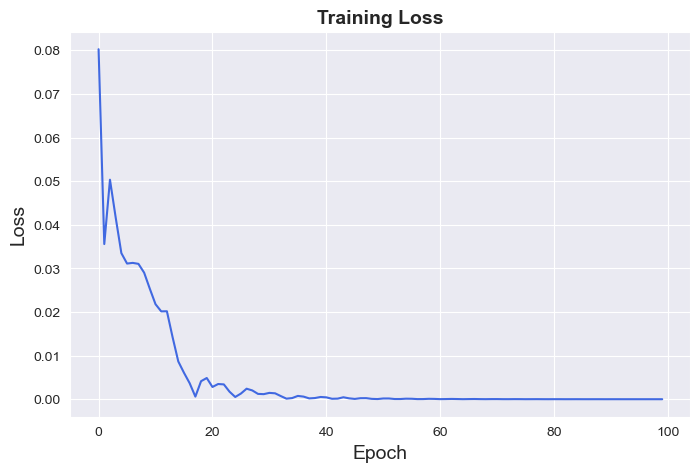

In [29]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam

hidden_dim = int(best_rnn_model['hidden_dim'])
num_layers = int(best_rnn_model['num_layers'])
time_step = int(best_rnn_model['time_step'])

torch.manual_seed(42)
tuned_rnn = RNN_relu(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
tuned_rnn = to_device(tuned_rnn, device)

evaluate_single_model(tuned_rnn, num_epochs, lr, loss_type, optimiser, time_step)

## Model Architecture (LSTM)

In [30]:
class LSTM_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device = device))
        c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device = device))
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [31]:
gc.collect()
torch.cuda.empty_cache()

## LSTM Model

Epoch  0 MSE:  0.040618978440761566
Epoch  1 MSE:  0.04281147941946983
Epoch  2 MSE:  0.036195024847984314
Epoch  3 MSE:  0.03292616829276085
Epoch  4 MSE:  0.032557085156440735
Epoch  5 MSE:  0.030960144475102425
Epoch  6 MSE:  0.026295436546206474
Epoch  7 MSE:  0.019574686884880066
Epoch  8 MSE:  0.014389541931450367
Epoch  9 MSE:  0.007475757040083408
Epoch  10 MSE:  0.0008210205123759806
Epoch  11 MSE:  0.010090870782732964
Epoch  12 MSE:  0.0070607322268188
Epoch  13 MSE:  0.0018260730430483818
Epoch  14 MSE:  0.0007192532648332417
Epoch  15 MSE:  0.001957071479409933
Epoch  16 MSE:  0.0034813072998076677
Epoch  17 MSE:  0.0039337510243058205
Epoch  18 MSE:  0.0032134391367435455
Epoch  19 MSE:  0.0019866065122187138
Epoch  20 MSE:  0.0012014649109914899
Epoch  21 MSE:  0.0009045402985066175
Epoch  22 MSE:  0.000983517151325941
Epoch  23 MSE:  0.0015868934569880366
Epoch  24 MSE:  0.00186759268399328
Epoch  25 MSE:  0.0017075836658477783
Epoch  26 MSE:  0.0013904622755944729
Epoc

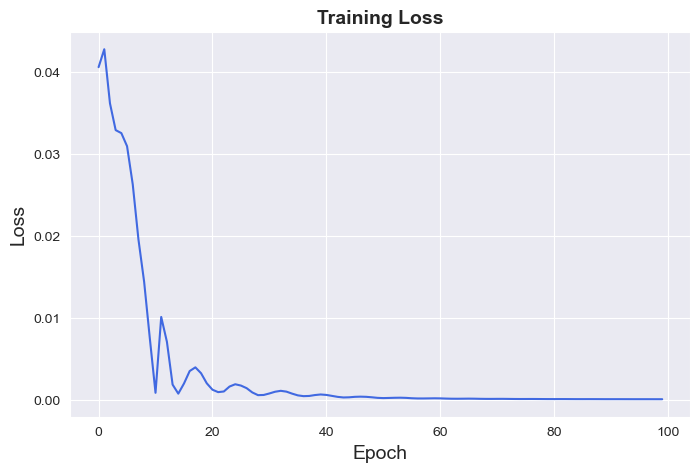

In [32]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam

hidden_dim = int(best_rnn_model['hidden_dim'])
num_layers = int(best_rnn_model['num_layers'])
time_step = int(best_rnn_model['time_step'])

torch.manual_seed(42)
lstm_1 = LSTM_model(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
lstm_1 = to_device(lstm_1, device)

evaluate_single_model(lstm_1, num_epochs, lr, loss_type, optimiser, time_step)

In [33]:
gc.collect()
torch.cuda.empty_cache()

## Hyper Parameter Tuning

In [34]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam

num_layers = [1, 2]
sliding_windows = [20, 30, 50, 100]
hidden_dims = [2, 4, 8, 16, 32]

LSTM_results=[]

for time_step in sliding_windows:
    for hidden_dim in hidden_dims:
        for layers in num_layers:

            gc.collect()
            torch.cuda.empty_cache()

            print("====================================================")
            print("Time Step =", time_step, "| Hidden States =", hidden_dim, "| Num Layers =", layers)
            print("====================================================")
            print()

            torch.manual_seed(42)
            lstm_exp = LSTM_model(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = layers)
            lstm_exp = to_device(lstm_exp, device)

            LSTM_res = evaluate_model_experiments(lstm_exp, num_epochs, lr, loss_type, optimiser, time_step)
            LSTM_results += [LSTM_res.iloc[0]]
            print()

Time Step = 20 | Hidden States = 2 | Num Layers = 1

Epoch  0 MSE:  0.09312347322702408
Epoch  1 MSE:  0.08503765612840652
Epoch  2 MSE:  0.07806186378002167
Epoch  3 MSE:  0.0720396339893341
Epoch  4 MSE:  0.06683067977428436
Epoch  5 MSE:  0.06231401860713959
Epoch  6 MSE:  0.058388471603393555
Epoch  7 MSE:  0.05497036874294281
Epoch  8 MSE:  0.05199102312326431
Epoch  9 MSE:  0.04939426854252815
Epoch  10 MSE:  0.047134049236774445
Epoch  11 MSE:  0.04517238214612007
Epoch  12 MSE:  0.043477535247802734
Epoch  13 MSE:  0.042022496461868286
Epoch  14 MSE:  0.04078375920653343
Epoch  15 MSE:  0.039740364998579025
Epoch  16 MSE:  0.03887315094470978
Epoch  17 MSE:  0.038164205849170685
Epoch  18 MSE:  0.03759652003645897
Epoch  19 MSE:  0.037153735756874084
Epoch  20 MSE:  0.03682004287838936
Epoch  21 MSE:  0.0365801565349102
Epoch  22 MSE:  0.036419350653886795
Epoch  23 MSE:  0.03632358834147453
Epoch  24 MSE:  0.03627965226769447
Epoch  25 MSE:  0.03627524897456169
Epoch  26 MSE: 

Epoch  6 MSE:  0.028265638276934624
Epoch  7 MSE:  0.026802033185958862
Epoch  8 MSE:  0.02471897006034851
Epoch  9 MSE:  0.022013423964381218
Epoch  10 MSE:  0.018835794180631638
Epoch  11 MSE:  0.015446249395608902
Epoch  12 MSE:  0.0121819619089365
Epoch  13 MSE:  0.009398289024829865
Epoch  14 MSE:  0.007339555770158768
Epoch  15 MSE:  0.005936325062066317
Epoch  16 MSE:  0.00476225558668375
Epoch  17 MSE:  0.003475409699603915
Epoch  18 MSE:  0.0022553580347448587
Epoch  19 MSE:  0.0016735362587496638
Epoch  20 MSE:  0.0021435911767184734
Epoch  21 MSE:  0.0033493235241621733
Epoch  22 MSE:  0.004397901240736246
Epoch  23 MSE:  0.004697822965681553
Epoch  24 MSE:  0.004306400194764137
Epoch  25 MSE:  0.003626349149271846
Epoch  26 MSE:  0.0030288593843579292
Epoch  27 MSE:  0.002633433323353529
Epoch  28 MSE:  0.00232895789667964
Epoch  29 MSE:  0.001985090086236596
Epoch  30 MSE:  0.001604872290045023
Epoch  31 MSE:  0.001288596075028181
Epoch  32 MSE:  0.0011267525842413306
Epoc

Epoch  9 MSE:  0.026775440201163292
Epoch  10 MSE:  0.024265071377158165
Epoch  11 MSE:  0.022158166393637657
Epoch  12 MSE:  0.020665429532527924
Epoch  13 MSE:  0.019741494208574295
Epoch  14 MSE:  0.019177567213773727
Epoch  15 MSE:  0.018694598227739334
Epoch  16 MSE:  0.018022865056991577
Epoch  17 MSE:  0.016962334513664246
Epoch  18 MSE:  0.015420733019709587
Epoch  19 MSE:  0.01342847291380167
Epoch  20 MSE:  0.0111320149153471
Epoch  21 MSE:  0.00876751821488142
Epoch  22 MSE:  0.006611123215407133
Epoch  23 MSE:  0.004893188830465078
Epoch  24 MSE:  0.0036720118951052427
Epoch  25 MSE:  0.0027532484382390976
Epoch  26 MSE:  0.0018820111872628331
Epoch  27 MSE:  0.0011631317902356386
Epoch  28 MSE:  0.0010896854801103473
Epoch  29 MSE:  0.0019411685643717647
Epoch  30 MSE:  0.0031294170767068863
Epoch  31 MSE:  0.0036110426299273968
Epoch  32 MSE:  0.003002812620252371
Epoch  33 MSE:  0.0017706271028146148
Epoch  34 MSE:  0.0006660091457888484
Epoch  35 MSE:  0.000192533319932

Epoch  12 MSE:  0.006530001759529114
Epoch  13 MSE:  0.003844093531370163
Epoch  14 MSE:  0.0005515284719876945
Epoch  15 MSE:  0.0007174302591010928
Epoch  16 MSE:  0.0011479513486847281
Epoch  17 MSE:  0.001312021166086197
Epoch  18 MSE:  0.0019177976064383984
Epoch  19 MSE:  0.0025622029788792133
Epoch  20 MSE:  0.0026190553326159716
Epoch  21 MSE:  0.0022416606079787016
Epoch  22 MSE:  0.0018987029325217009
Epoch  23 MSE:  0.0016421128530055285
Epoch  24 MSE:  0.001196470926515758
Epoch  25 MSE:  0.0005822759703733027
Epoch  26 MSE:  0.00021332601318135858
Epoch  27 MSE:  0.00023780783521942794
Epoch  28 MSE:  0.00031020137248560786
Epoch  29 MSE:  0.0003875640977639705
Epoch  30 MSE:  0.0006926088244654238
Epoch  31 MSE:  0.0008866877760738134
Epoch  32 MSE:  0.0007205175934359431
Epoch  33 MSE:  0.000524865579791367
Epoch  34 MSE:  0.00038882874650880694
Epoch  35 MSE:  0.00018657397595234215
Epoch  36 MSE:  6.500500603578985e-05
Epoch  37 MSE:  0.00011949735198868439
Epoch  38 M

Epoch  12 MSE:  0.01175837591290474
Epoch  13 MSE:  0.003141402965411544
Epoch  14 MSE:  0.0015027684858068824
Epoch  15 MSE:  0.005173086654394865
Epoch  16 MSE:  0.006386267952620983
Epoch  17 MSE:  0.0044372957199811935
Epoch  18 MSE:  0.0014774819137528539
Epoch  19 MSE:  0.00033436642843298614
Epoch  20 MSE:  0.002040162682533264
Epoch  21 MSE:  0.0034192902967333794
Epoch  22 MSE:  0.002188729587942362
Epoch  23 MSE:  0.0006446552579291165
Epoch  24 MSE:  0.0004921055515296757
Epoch  25 MSE:  0.0012262987438589334
Epoch  26 MSE:  0.0018178564496338367
Epoch  27 MSE:  0.0017250403761863708
Epoch  28 MSE:  0.0010487979743629694
Epoch  29 MSE:  0.0003498228034004569
Epoch  30 MSE:  0.00022648346202913672
Epoch  31 MSE:  0.0007135641644708812
Epoch  32 MSE:  0.0011146441102027893
Epoch  33 MSE:  0.0008929803152568638
Epoch  34 MSE:  0.00039733698940835893
Epoch  35 MSE:  0.00020610468345694244
Epoch  36 MSE:  0.0003865587350446731
Epoch  37 MSE:  0.0006218919297680259
Epoch  38 MSE: 

Epoch  15 MSE:  0.039760932326316833
Epoch  16 MSE:  0.03889548406004906
Epoch  17 MSE:  0.038188185542821884
Epoch  18 MSE:  0.03762201964855194
Epoch  19 MSE:  0.037180621176958084
Epoch  20 MSE:  0.03684817627072334
Epoch  21 MSE:  0.03660937771201134
Epoch  22 MSE:  0.03644951805472374
Epoch  23 MSE:  0.03635454922914505
Epoch  24 MSE:  0.036311253905296326
Epoch  25 MSE:  0.03630734980106354
Epoch  26 MSE:  0.036331672221422195
Epoch  27 MSE:  0.036374274641275406
Epoch  28 MSE:  0.03642651438713074
Epoch  29 MSE:  0.036481112241744995
Epoch  30 MSE:  0.036532171070575714
Epoch  31 MSE:  0.03657514229416847
Epoch  32 MSE:  0.03660673648118973
Epoch  33 MSE:  0.03662484139204025
Epoch  34 MSE:  0.03662838041782379
Epoch  35 MSE:  0.03661717474460602
Epoch  36 MSE:  0.03659175708889961
Epoch  37 MSE:  0.036553237587213516
Epoch  38 MSE:  0.03650311008095741
Epoch  39 MSE:  0.036443136632442474
Epoch  40 MSE:  0.03637517988681793
Epoch  41 MSE:  0.03630111366510391
Epoch  42 MSE:  0.

Epoch  23 MSE:  0.0048709437251091
Epoch  24 MSE:  0.004348276648670435
Epoch  25 MSE:  0.00355468038469553
Epoch  26 MSE:  0.0028616113122552633
Epoch  27 MSE:  0.0024030141066759825
Epoch  28 MSE:  0.002096304204314947
Epoch  29 MSE:  0.0018178171012550592
Epoch  30 MSE:  0.001538876909762621
Epoch  31 MSE:  0.0013157770736142993
Epoch  32 MSE:  0.001211556838825345
Epoch  33 MSE:  0.0012428341433405876
Epoch  34 MSE:  0.0013726343167945743
Epoch  35 MSE:  0.0015327882720157504
Epoch  36 MSE:  0.0016548993298783898
Epoch  37 MSE:  0.001694605452939868
Epoch  38 MSE:  0.0016417906153947115
Epoch  39 MSE:  0.0015167758101597428
Epoch  40 MSE:  0.001357093802653253
Epoch  41 MSE:  0.0012010388309136033
Epoch  42 MSE:  0.001073990948498249
Epoch  43 MSE:  0.000982323894277215
Epoch  44 MSE:  0.0009170204866677523
Epoch  45 MSE:  0.0008645985508337617
Epoch  46 MSE:  0.0008184402831830084
Epoch  47 MSE:  0.0007829301757737994
Epoch  48 MSE:  0.0007677828543819487
Epoch  49 MSE:  0.0007773

Epoch  28 MSE:  0.0011715007713064551
Epoch  29 MSE:  0.0019882519263774157
Epoch  30 MSE:  0.003120464039966464
Epoch  31 MSE:  0.0035563751589506865
Epoch  32 MSE:  0.0029258837457746267
Epoch  33 MSE:  0.0016933819279074669
Epoch  34 MSE:  0.0006076114950701594
Epoch  35 MSE:  0.0001712307275738567
Epoch  36 MSE:  0.00038035493344068527
Epoch  37 MSE:  0.0008281996706500649
Epoch  38 MSE:  0.001097658067010343
Epoch  39 MSE:  0.001068838289938867
Epoch  40 MSE:  0.0008871317259036005
Epoch  41 MSE:  0.0007472841534763575
Epoch  42 MSE:  0.0007358352304436266
Epoch  43 MSE:  0.0008078821701928973
Epoch  44 MSE:  0.0008529640035703778
Epoch  45 MSE:  0.0007814120035618544
Epoch  46 MSE:  0.0005823375540785491
Epoch  47 MSE:  0.00033112018718384206
Epoch  48 MSE:  0.0001460440835217014
Epoch  49 MSE:  0.00011262156476732343
Epoch  50 MSE:  0.00021734654728788882
Epoch  51 MSE:  0.0003498413134366274
Epoch  52 MSE:  0.0003953797568101436
Epoch  53 MSE:  0.0003365898737683892
Epoch  54 M

Epoch  30 MSE:  0.0005734095466323197
Epoch  31 MSE:  0.0007965457625687122
Epoch  32 MSE:  0.0008422203827649355
Epoch  33 MSE:  0.0005706222145818174
Epoch  34 MSE:  0.00033739974605850875
Epoch  35 MSE:  0.00025112341972999275
Epoch  36 MSE:  0.00014808526611886919
Epoch  37 MSE:  6.950321403564885e-05
Epoch  38 MSE:  0.00012719356163870543
Epoch  39 MSE:  0.00024090603983495384
Epoch  40 MSE:  0.00028710748301818967
Epoch  41 MSE:  0.00028150028083473444
Epoch  42 MSE:  0.00028913296409882605
Epoch  43 MSE:  0.00028784488677047193
Epoch  44 MSE:  0.00022641062969341874
Epoch  45 MSE:  0.00013911040150560439
Epoch  46 MSE:  9.39742021728307e-05
Epoch  47 MSE:  8.34099409985356e-05
Epoch  48 MSE:  6.718535587424412e-05
Epoch  49 MSE:  6.499709706986323e-05
Epoch  50 MSE:  0.00010230411862721667
Epoch  51 MSE:  0.00013571100134868175
Epoch  52 MSE:  0.00013091351138427854
Epoch  53 MSE:  0.00011768293188652024
Epoch  54 MSE:  0.00010897273750742897
Epoch  55 MSE:  8.383749809581786e-0

Epoch  31 MSE:  0.0003889810177497566
Epoch  32 MSE:  0.0003182347572874278
Epoch  33 MSE:  0.0008075948571786284
Epoch  34 MSE:  0.001228843117132783
Epoch  35 MSE:  0.0011098356917500496
Epoch  36 MSE:  0.0006317998631857336
Epoch  37 MSE:  0.0002763795491773635
Epoch  38 MSE:  0.0002739683259278536
Epoch  39 MSE:  0.0005055696237832308
Epoch  40 MSE:  0.000719877309165895
Epoch  41 MSE:  0.0007443659123964608
Epoch  42 MSE:  0.0005712505080737174
Epoch  43 MSE:  0.00033099157735705376
Epoch  44 MSE:  0.00019156307098455727
Epoch  45 MSE:  0.00023239065194502473
Epoch  46 MSE:  0.0003758188395295292
Epoch  47 MSE:  0.00045825494453310966
Epoch  48 MSE:  0.00039614835986867547
Epoch  49 MSE:  0.00026106322184205055
Epoch  50 MSE:  0.00017998585826717317
Epoch  51 MSE:  0.00020134798251092434
Epoch  52 MSE:  0.00027185663930140436
Epoch  53 MSE:  0.00030934979440644383
Epoch  54 MSE:  0.0002779447822831571
Epoch  55 MSE:  0.00020721962209790945
Epoch  56 MSE:  0.0001565559214213863
Epo

Epoch  35 MSE:  0.03668108955025673
Epoch  36 MSE:  0.03665526956319809
Epoch  37 MSE:  0.03661637008190155
Epoch  38 MSE:  0.036565907299518585
Epoch  39 MSE:  0.036505650728940964
Epoch  40 MSE:  0.036437466740608215
Epoch  41 MSE:  0.03636322543025017
Epoch  42 MSE:  0.0362846814095974
Epoch  43 MSE:  0.03620341792702675
Epoch  44 MSE:  0.03612075746059418
Epoch  45 MSE:  0.036037739366292953
Epoch  46 MSE:  0.03595511615276337
Epoch  47 MSE:  0.03587330877780914
Epoch  48 MSE:  0.03579244390130043
Epoch  49 MSE:  0.035712357610464096
Epoch  50 MSE:  0.035632628947496414
Epoch  51 MSE:  0.03555260971188545
Epoch  52 MSE:  0.03547144681215286
Epoch  53 MSE:  0.035388123244047165
Epoch  54 MSE:  0.03530150279402733
Epoch  55 MSE:  0.035210322588682175
Epoch  56 MSE:  0.03511323779821396
Epoch  57 MSE:  0.03500884771347046
Epoch  58 MSE:  0.034895654767751694
Epoch  59 MSE:  0.034772101789712906
Epoch  60 MSE:  0.034636545926332474
Epoch  61 MSE:  0.034487225115299225
Epoch  62 MSE:  0

Epoch  39 MSE:  0.0014683620538562536
Epoch  40 MSE:  0.0012975090648978949
Epoch  41 MSE:  0.0011319806799292564
Epoch  42 MSE:  0.001000057440251112
Epoch  43 MSE:  0.0009105589706450701
Epoch  44 MSE:  0.0008548147161491215
Epoch  45 MSE:  0.0008169591310434043
Epoch  46 MSE:  0.0007861144258640707
Epoch  47 MSE:  0.0007623882265761495
Epoch  48 MSE:  0.0007529360009357333
Epoch  49 MSE:  0.0007619571988470852
Epoch  50 MSE:  0.0007830730173736811
Epoch  51 MSE:  0.0008003425900824368
Epoch  52 MSE:  0.0007971310988068581
Epoch  53 MSE:  0.0007661162526346743
Epoch  54 MSE:  0.0007133962935768068
Epoch  55 MSE:  0.0006544270436279476
Epoch  56 MSE:  0.0006051636883057654
Epoch  57 MSE:  0.0005742881330661476
Epoch  58 MSE:  0.0005608081701211631
Epoch  59 MSE:  0.0005573479575105011
Epoch  60 MSE:  0.0005559190758503973
Epoch  61 MSE:  0.0005521267303265631
Epoch  62 MSE:  0.0005457376828417182
Epoch  63 MSE:  0.0005383959505707026
Epoch  64 MSE:  0.0005308915278874338
Epoch  65 MSE

Epoch  43 MSE:  0.0007955388864502311
Epoch  44 MSE:  0.000846494163852185
Epoch  45 MSE:  0.0007804576889611781
Epoch  46 MSE:  0.0005841376259922981
Epoch  47 MSE:  0.000332698633428663
Epoch  48 MSE:  0.00014600876602344215
Epoch  49 MSE:  0.00011173709208378568
Epoch  50 MSE:  0.00021754682529717684
Epoch  51 MSE:  0.0003522115875966847
Epoch  52 MSE:  0.00039872725028544664
Epoch  53 MSE:  0.00033821017132140696
Epoch  54 MSE:  0.00024858381948433816
Epoch  55 MSE:  0.00020865142869297415
Epoch  56 MSE:  0.00022544532839674503
Epoch  57 MSE:  0.00024867671891115606
Epoch  58 MSE:  0.00023224939650390297
Epoch  59 MSE:  0.0001753529504640028
Epoch  60 MSE:  0.0001159582388936542
Epoch  61 MSE:  9.398382826475427e-05
Epoch  62 MSE:  0.00011814806930487975
Epoch  63 MSE:  0.00016158765356522053
Epoch  64 MSE:  0.0001868795952759683
Epoch  65 MSE:  0.00017680057499092072
Epoch  66 MSE:  0.0001440385967725888
Epoch  67 MSE:  0.0001148698793258518
Epoch  68 MSE:  0.00010543044481892139


Epoch  45 MSE:  0.0001281245640711859
Epoch  46 MSE:  9.245367982657626e-05
Epoch  47 MSE:  8.051433542277664e-05
Epoch  48 MSE:  6.1412101786118e-05
Epoch  49 MSE:  6.619438499910757e-05
Epoch  50 MSE:  0.0001072640807251446
Epoch  51 MSE:  0.00013296958059072495
Epoch  52 MSE:  0.00012485070328693837
Epoch  53 MSE:  0.00011626279592746869
Epoch  54 MSE:  0.000106322746432852
Epoch  55 MSE:  7.698859553784132e-05
Epoch  56 MSE:  5.086490273242816e-05
Epoch  57 MSE:  4.889835690846667e-05
Epoch  58 MSE:  5.412191603682004e-05
Epoch  59 MSE:  5.5292563047260046e-05
Epoch  60 MSE:  6.307630246737972e-05
Epoch  61 MSE:  7.464266673196107e-05
Epoch  62 MSE:  7.475032907677814e-05
Epoch  63 MSE:  6.580259650945663e-05
Epoch  64 MSE:  5.957728353678249e-05
Epoch  65 MSE:  5.387235069065355e-05
Epoch  66 MSE:  4.46718986495398e-05
Epoch  67 MSE:  4.027943577966653e-05
Epoch  68 MSE:  4.393967174110003e-05
Epoch  69 MSE:  4.726933184429072e-05
Epoch  70 MSE:  4.841410191147588e-05
Epoch  71 MS

Epoch  46 MSE:  0.0002086346794385463
Epoch  47 MSE:  0.0002099591656588018
Epoch  48 MSE:  0.0003165457455907017
Epoch  49 MSE:  0.0004134720948059112
Epoch  50 MSE:  0.00041081238305196166
Epoch  51 MSE:  0.00032002420630306005
Epoch  52 MSE:  0.00022663624258711934
Epoch  53 MSE:  0.0001994183985516429
Epoch  54 MSE:  0.00023606611648574471
Epoch  55 MSE:  0.00028307962929829955
Epoch  56 MSE:  0.00029052834725007415
Epoch  57 MSE:  0.00024958403082564473
Epoch  58 MSE:  0.00019139026699122041
Epoch  59 MSE:  0.00015724514378234744
Epoch  60 MSE:  0.0001654002262512222
Epoch  61 MSE:  0.0001988519506994635
Epoch  62 MSE:  0.0002226808137493208
Epoch  63 MSE:  0.00021507339261006564
Epoch  64 MSE:  0.00018364464631304145
Epoch  65 MSE:  0.0001540029188618064
Epoch  66 MSE:  0.00014510267646983266
Epoch  67 MSE:  0.00015524936316069216
Epoch  68 MSE:  0.00016796936688479036
Epoch  69 MSE:  0.00016849118401296437
Epoch  70 MSE:  0.00015558874292764813
Epoch  71 MSE:  0.0001402921188855

Epoch  47 MSE:  0.03602901101112366
Epoch  48 MSE:  0.03594832494854927
Epoch  49 MSE:  0.03586842119693756
Epoch  50 MSE:  0.035788845270872116
Epoch  51 MSE:  0.03570893779397011
Epoch  52 MSE:  0.0356278195977211
Epoch  53 MSE:  0.03554445877671242
Epoch  54 MSE:  0.035457707941532135
Epoch  55 MSE:  0.03536628931760788
Epoch  56 MSE:  0.035268861800432205
Epoch  57 MSE:  0.035163991153240204
Epoch  58 MSE:  0.03505019471049309
Epoch  59 MSE:  0.034925904124975204
Epoch  60 MSE:  0.03478946164250374
Epoch  61 MSE:  0.03463910147547722
Epoch  62 MSE:  0.03447289019823074
Epoch  63 MSE:  0.03428870067000389
Epoch  64 MSE:  0.034084126353263855
Epoch  65 MSE:  0.03385641425848007
Epoch  66 MSE:  0.033602386713027954
Epoch  67 MSE:  0.03331829607486725
Epoch  68 MSE:  0.03299974650144577
Epoch  69 MSE:  0.03264150395989418
Epoch  70 MSE:  0.03223734721541405
Epoch  71 MSE:  0.03177986666560173
Epoch  72 MSE:  0.031260229647159576
Epoch  73 MSE:  0.03066794015467167
Epoch  74 MSE:  0.029

Epoch  51 MSE:  0.00079396553337574
Epoch  52 MSE:  0.0007878605392761528
Epoch  53 MSE:  0.0007541421218775213
Epoch  54 MSE:  0.0007000665063969791
Epoch  55 MSE:  0.0006415907992050052
Epoch  56 MSE:  0.0005942978314124048
Epoch  57 MSE:  0.0005659176968038082
Epoch  58 MSE:  0.0005544981686398387
Epoch  59 MSE:  0.0005521701532416046
Epoch  60 MSE:  0.0005510322516784072
Epoch  61 MSE:  0.0005471139447763562
Epoch  62 MSE:  0.0005405788542702794
Epoch  63 MSE:  0.0005332086584530771
Epoch  64 MSE:  0.0005256850854493678
Epoch  65 MSE:  0.0005166832706891
Epoch  66 MSE:  0.0005040796240791678
Epoch  67 MSE:  0.000487044540932402
Epoch  68 MSE:  0.00046729345922358334
Epoch  69 MSE:  0.00044850539416074753
Epoch  70 MSE:  0.000434272427810356
Epoch  71 MSE:  0.0004259988490957767
Epoch  72 MSE:  0.00042221855255775154
Epoch  73 MSE:  0.0004197638772893697
Epoch  74 MSE:  0.0004158549418207258
Epoch  75 MSE:  0.0004095397307537496
Epoch  76 MSE:  0.00040157148032449186
Epoch  77 MSE: 

Epoch  56 MSE:  0.00022308871848508716
Epoch  57 MSE:  0.00024785444838926196
Epoch  58 MSE:  0.00023423777020070702
Epoch  59 MSE:  0.00017898279475048184
Epoch  60 MSE:  0.00011886670836247504
Epoch  61 MSE:  9.461567969992757e-05
Epoch  62 MSE:  0.00011691165855154395
Epoch  63 MSE:  0.00016031123232096434
Epoch  64 MSE:  0.00018712003657128662
Epoch  65 MSE:  0.00017857567581813782
Epoch  66 MSE:  0.00014606190961785614
Epoch  67 MSE:  0.0001158704690169543
Epoch  68 MSE:  0.00010522508819121867
Epoch  69 MSE:  0.00011103033466497436
Epoch  70 MSE:  0.00011755001469282433
Epoch  71 MSE:  0.00011277392331976444
Epoch  72 MSE:  9.854247764451429e-05
Epoch  73 MSE:  8.699481259100139e-05
Epoch  74 MSE:  8.788908598944545e-05
Epoch  75 MSE:  9.894956019707024e-05
Epoch  76 MSE:  0.00010837974696187302
Epoch  77 MSE:  0.00010665575973689556
Epoch  78 MSE:  9.516729915048927e-05
Epoch  79 MSE:  8.335062739206478e-05
Epoch  80 MSE:  7.884449587436393e-05
Epoch  81 MSE:  8.136353426380083e

Epoch  57 MSE:  5.269060784485191e-05
Epoch  58 MSE:  5.208008224144578e-05
Epoch  59 MSE:  5.824834079248831e-05
Epoch  60 MSE:  7.204093708423898e-05
Epoch  61 MSE:  7.644862489541993e-05
Epoch  62 MSE:  6.985025538597256e-05
Epoch  63 MSE:  6.423674494726583e-05
Epoch  64 MSE:  5.858202348463237e-05
Epoch  65 MSE:  4.8044832510640845e-05
Epoch  66 MSE:  4.122583050047979e-05
Epoch  67 MSE:  4.3134481529705226e-05
Epoch  68 MSE:  4.5853415940655395e-05
Epoch  69 MSE:  4.726354018202983e-05
Epoch  70 MSE:  5.1199367590015754e-05
Epoch  71 MSE:  5.3080344514455646e-05
Epoch  72 MSE:  4.936729237670079e-05
Epoch  73 MSE:  4.555728446575813e-05
Epoch  74 MSE:  4.3411084334366024e-05
Epoch  75 MSE:  4.040699786855839e-05
Epoch  76 MSE:  3.901268064510077e-05
Epoch  77 MSE:  4.0871440432965755e-05
Epoch  78 MSE:  4.243810326443054e-05
Epoch  79 MSE:  4.274189268471673e-05
Epoch  80 MSE:  4.3413896491983905e-05
Epoch  81 MSE:  4.310686563258059e-05
Epoch  82 MSE:  4.106956475879997e-05
Epoc

Epoch  57 MSE:  0.0002811622398439795
Epoch  58 MSE:  0.0002316344325663522
Epoch  59 MSE:  0.0001762215979397297
Epoch  60 MSE:  0.0001507862762082368
Epoch  61 MSE:  0.0001648826291784644
Epoch  62 MSE:  0.00019736927060876042
Epoch  63 MSE:  0.0002165812038583681
Epoch  64 MSE:  0.0002068586618406698
Epoch  65 MSE:  0.0001782803883543238
Epoch  66 MSE:  0.00015354788047261536
Epoch  67 MSE:  0.00014724383072461933
Epoch  68 MSE:  0.00015614062431268394
Epoch  69 MSE:  0.00016572153253946453
Epoch  70 MSE:  0.00016414849960710853
Epoch  71 MSE:  0.00015143907512538135
Epoch  72 MSE:  0.0001376225263811648
Epoch  73 MSE:  0.00013279738777782768
Epoch  74 MSE:  0.00013810672680847347
Epoch  75 MSE:  0.0001454928278690204
Epoch  76 MSE:  0.00014595576794818044
Epoch  77 MSE:  0.0001378853339701891
Epoch  78 MSE:  0.0001274741516681388
Epoch  79 MSE:  0.0001219045152538456
Epoch  80 MSE:  0.00012289703590795398
Epoch  81 MSE:  0.00012638041516765952
Epoch  82 MSE:  0.00012722429528366774

In [35]:
LSTM_results = pd.DataFrame(LSTM_results, columns=['time_step', 'num_layers', 'hidden_dim', 'trainScore', 'valScore'], index = None)

In [36]:
LSTM_results = LSTM_results.sort_values('valScore', ascending=True, ignore_index = True)  
LSTM_results

time_step  num_layers  hidden_dim  trainScore   valScore
0        20.0         2.0        32.0    0.183898   3.353715
1        30.0         2.0        32.0    0.191065   3.398010
2        50.0         2.0        32.0    0.210327   4.301537
3       100.0         2.0        16.0    0.190670   4.511294
4        50.0         2.0        16.0    0.191541   4.528789
5       100.0         2.0        32.0    0.217563   4.937522
6        50.0         1.0        16.0    0.183526   5.014984
7        30.0         1.0        16.0    0.185471   5.037486
8       100.0         1.0        16.0    0.183330   5.103107
9        20.0         1.0        16.0    0.189064   5.119752
10       30.0         2.0        16.0    0.199778   5.293988
11       30.0         1.0         8.0    0.250768   5.803946
12       50.0         1.0         8.0    0.250364   5.835172
13       20.0         1.0         8.0    0.252050   5.862777
14      100.0         1.0         8.0    0.250940   5.981001
15       20.0         1.0        32.0    0.248382   6.055101
16       20.0         2.0        16.0    0.209868   6.119395
17       30.0         1.0        32.0    0.273482   6.347491
18       50.0         1.0        32.0    0.294004   6.640990
19      100.0         1.0        32.0    0.298576   6.774301
20       50.0         1.0         4.0    0.483148  10.029259
21       30.0         1.0         4.0    0.490937  10.049406
22      100.0         1.0         4.0    0.481717  10.236452
23       20.0         1.0         4.0    0.508500  10.256740
24       50.0         2.0         8.0    0.332756  12.093705
25       30.0         2.0         8.0    0.328463  12.103140
26      100.0         2.0         8.0    0.334082  12.263771
27       20.0         2.0         8.0    0.378380  12.322964
28       30.0         2.0         2.0    0.592207  13.141265
29       50.0         2.0         2.0    0.589061  13.207722
30       20.0         2.0         2.0    0.620932  13.352711
31      100.0         2.0         2.0    0.592736  13.520443
32       30.0         2.0         4.0    0.866593  15.074994
33       50.0         2.0         4.0    0.861307  15.130204
34       20.0         2.0         4.0    0.877747  15.173122
35      100.0         2.0         4.0    0.864794  15.404663
36       20.0         1.0         2.0    1.473281  16.385214
37       30.0         1.0         2.0    1.397408  16.527496
38       50.0         1.0         2.0    1.359005  16.672426
39      100.0         1.0         2.0    1.340623  17.035766

## Selecting Best Model (LSTM Model)

In [37]:
best_lstm_model = LSTM_results.iloc[0]
best_lstm_model

time_step     20.000000
num_layers     2.000000
hidden_dim    32.000000
trainScore     0.183898
valScore       3.353715
Name: 0, dtype: float64

Epoch  0 MSE:  0.040618978440761566
Epoch  1 MSE:  0.04281147941946983
Epoch  2 MSE:  0.036195024847984314
Epoch  3 MSE:  0.03292616829276085
Epoch  4 MSE:  0.032557085156440735
Epoch  5 MSE:  0.030960144475102425
Epoch  6 MSE:  0.026295436546206474
Epoch  7 MSE:  0.019574686884880066
Epoch  8 MSE:  0.014389541931450367
Epoch  9 MSE:  0.007475757040083408
Epoch  10 MSE:  0.0008210205123759806
Epoch  11 MSE:  0.010090870782732964
Epoch  12 MSE:  0.0070607322268188
Epoch  13 MSE:  0.0018260730430483818
Epoch  14 MSE:  0.0007192532648332417
Epoch  15 MSE:  0.001957071479409933
Epoch  16 MSE:  0.0034813072998076677
Epoch  17 MSE:  0.0039337510243058205
Epoch  18 MSE:  0.0032134391367435455
Epoch  19 MSE:  0.0019866065122187138
Epoch  20 MSE:  0.0012014649109914899
Epoch  21 MSE:  0.0009045402985066175
Epoch  22 MSE:  0.000983517151325941
Epoch  23 MSE:  0.0015868934569880366
Epoch  24 MSE:  0.00186759268399328
Epoch  25 MSE:  0.0017075836658477783
Epoch  26 MSE:  0.0013904622755944729
Epoc

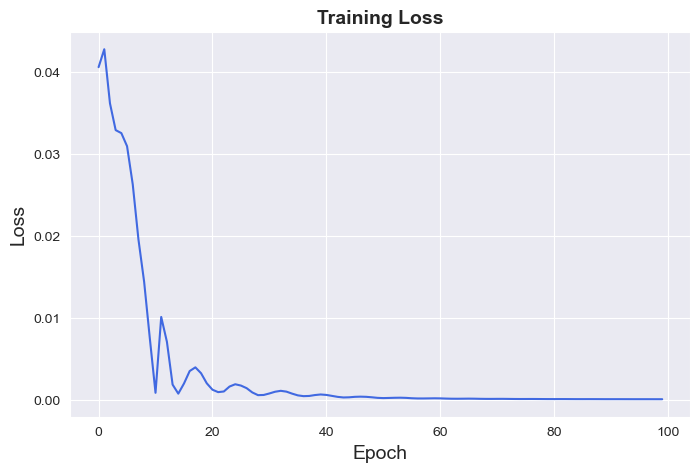

In [38]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam

hidden_dim = int(best_lstm_model['hidden_dim'])
num_layers = int(best_lstm_model['num_layers'])
time_step = int(best_lstm_model['time_step'])

torch.manual_seed(42)
tuned_lstm = LSTM_model(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
tuned_lstm = to_device(tuned_lstm, device)

evaluate_single_model(tuned_lstm, num_epochs, lr, loss_type, optimiser, time_step)

## Model Architecture (GRU)

In [39]:
class GRU_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(GRU_model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        
        self.gru = nn.GRU(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device = device))
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [40]:
gc.collect()
torch.cuda.empty_cache()

## GRU Model

Epoch  0 MSE:  0.07179559022188187
Epoch  1 MSE:  0.053293388336896896
Epoch  2 MSE:  0.04245859757065773
Epoch  3 MSE:  0.02891470678150654
Epoch  4 MSE:  0.028615588322281837
Epoch  5 MSE:  0.028290200978517532
Epoch  6 MSE:  0.020927928388118744
Epoch  7 MSE:  0.011481642723083496
Epoch  8 MSE:  0.008736717514693737
Epoch  9 MSE:  0.009971647523343563
Epoch  10 MSE:  0.002672072034329176
Epoch  11 MSE:  0.002599109197035432
Epoch  12 MSE:  0.009029964916408062
Epoch  13 MSE:  0.0048012034967541695
Epoch  14 MSE:  0.000365995365427807
Epoch  15 MSE:  0.0012147922534495592
Epoch  16 MSE:  0.0032251854427158833
Epoch  17 MSE:  0.003329699393361807
Epoch  18 MSE:  0.0024801664985716343
Epoch  19 MSE:  0.0020592212677001953
Epoch  20 MSE:  0.0021666716784238815
Epoch  21 MSE:  0.0021524960175156593
Epoch  22 MSE:  0.0015332387993112206
Epoch  23 MSE:  0.0005607558996416628
Epoch  24 MSE:  0.0001422767381882295
Epoch  25 MSE:  0.0008216415881179273
Epoch  26 MSE:  0.001618026290088892
Epo

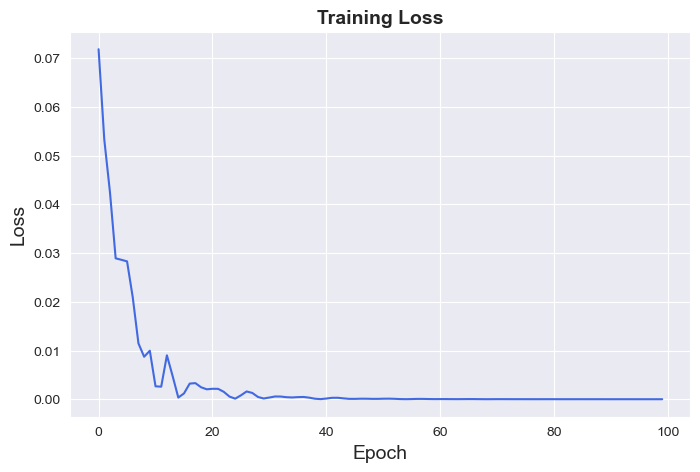

In [41]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam

hidden_dim = int(best_lstm_model['hidden_dim'])
num_layers = int(best_lstm_model['num_layers'])
time_step = int(best_lstm_model['time_step'])

torch.manual_seed(42)
gru = GRU_model(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
gru = to_device(gru, device)

evaluate_single_model(gru, num_epochs, lr, loss_type, optimiser, time_step)

In [42]:
gc.collect()
torch.cuda.empty_cache()

## Hyper Parameters Tuning

In [43]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam

num_layers = [1, 2]
sliding_windows = [20, 30, 50, 100]
hidden_dims = [2, 4, 8, 16, 32]

GRU_results=[]

for time_step in sliding_windows:
    for hidden_dim in hidden_dims:
        for layers in num_layers:

            gc.collect()
            torch.cuda.empty_cache()

            print("====================================================")
            print("Time Step =", time_step, "| Hidden States =", hidden_dim, "| Num Layers =", layers)
            print("====================================================")
            print()

            torch.manual_seed(42)
            gru_exp = GRU_model(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = layers)
            gru_exp = to_device(gru_exp, device)

            GRU_res = evaluate_model_experiments(gru_exp, num_epochs, lr, loss_type, optimiser, time_step)
            GRU_results += [GRU_res.iloc[0]]
            print()


Time Step = 20 | Hidden States = 2 | Num Layers = 1

Epoch  0 MSE:  0.07427381724119186
Epoch  1 MSE:  0.06199593096971512
Epoch  2 MSE:  0.052362293004989624
Epoch  3 MSE:  0.04557616263628006
Epoch  4 MSE:  0.04164762794971466
Epoch  5 MSE:  0.04021786153316498
Epoch  6 MSE:  0.040409237146377563
Epoch  7 MSE:  0.040988076478242874
Epoch  8 MSE:  0.04094001278281212
Epoch  9 MSE:  0.03987399488687515
Epoch  10 MSE:  0.03793422877788544
Epoch  11 MSE:  0.03552033379673958
Epoch  12 MSE:  0.03306340053677559
Epoch  13 MSE:  0.03089897148311138
Epoch  14 MSE:  0.029210686683654785
Epoch  15 MSE:  0.02802242711186409
Epoch  16 MSE:  0.02722751721739769
Epoch  17 MSE:  0.02664337493479252
Epoch  18 MSE:  0.026074957102537155
Epoch  19 MSE:  0.025368213653564453
Epoch  20 MSE:  0.024440977722406387
Epoch  21 MSE:  0.023288598284125328
Epoch  22 MSE:  0.021969566121697426
Epoch  23 MSE:  0.02057962864637375
Epoch  24 MSE:  0.019222039729356766
Epoch  25 MSE:  0.017980000004172325
Epoch  26 

Epoch  0 MSE:  0.10166198760271072
Epoch  1 MSE:  0.07806313782930374
Epoch  2 MSE:  0.05883245915174484
Epoch  3 MSE:  0.04377719759941101
Epoch  4 MSE:  0.03265264630317688
Epoch  5 MSE:  0.025117725133895874
Epoch  6 MSE:  0.020722882822155952
Epoch  7 MSE:  0.018919575959444046
Epoch  8 MSE:  0.019068384543061256
Epoch  9 MSE:  0.020457273349165916
Epoch  10 MSE:  0.0223575159907341
Epoch  11 MSE:  0.024120664224028587
Epoch  12 MSE:  0.02527637593448162
Epoch  13 MSE:  0.025580625981092453
Epoch  14 MSE:  0.025000352412462234
Epoch  15 MSE:  0.02365824207663536
Epoch  16 MSE:  0.02176825702190399
Epoch  17 MSE:  0.019579490646719933
Epoch  18 MSE:  0.0173338633030653
Epoch  19 MSE:  0.01523686945438385
Epoch  20 MSE:  0.013439159840345383
Epoch  21 MSE:  0.012027110904455185
Epoch  22 MSE:  0.011021466925740242
Epoch  23 MSE:  0.01038355752825737
Epoch  24 MSE:  0.010028253309428692
Epoch  25 MSE:  0.009842008352279663
Epoch  26 MSE:  0.009703303687274456
Epoch  27 MSE:  0.0095024

Epoch  6 MSE:  0.040242090821266174
Epoch  7 MSE:  0.03601611405611038
Epoch  8 MSE:  0.036574043333530426
Epoch  9 MSE:  0.040004193782806396
Epoch  10 MSE:  0.04396714270114899
Epoch  11 MSE:  0.04660268500447273
Epoch  12 MSE:  0.04711340740323067
Epoch  13 MSE:  0.0455918163061142
Epoch  14 MSE:  0.042598381638526917
Epoch  15 MSE:  0.03882305324077606
Epoch  16 MSE:  0.03488631546497345
Epoch  17 MSE:  0.031248940154910088
Epoch  18 MSE:  0.02819124609231949
Epoch  19 MSE:  0.025831513106822968
Epoch  20 MSE:  0.024162452667951584
Epoch  21 MSE:  0.023092053830623627
Epoch  22 MSE:  0.022480985149741173
Epoch  23 MSE:  0.022172782570123672
Epoch  24 MSE:  0.02201603539288044
Epoch  25 MSE:  0.02187914028763771
Epoch  26 MSE:  0.021658923476934433
Epoch  27 MSE:  0.02128439210355282
Epoch  28 MSE:  0.020716864615678787
Epoch  29 MSE:  0.019947415217757225
Epoch  30 MSE:  0.01899244450032711
Epoch  31 MSE:  0.01788805052638054
Epoch  32 MSE:  0.01668361946940422
Epoch  33 MSE:  0.01

Epoch  8 MSE:  0.022762421518564224
Epoch  9 MSE:  0.021611005067825317
Epoch  10 MSE:  0.021197443827986717
Epoch  11 MSE:  0.02060309424996376
Epoch  12 MSE:  0.01924586296081543
Epoch  13 MSE:  0.0171081330627203
Epoch  14 MSE:  0.014598134905099869
Epoch  15 MSE:  0.012272704392671585
Epoch  16 MSE:  0.01055016741156578
Epoch  17 MSE:  0.009449181146919727
Epoch  18 MSE:  0.00850654672831297
Epoch  19 MSE:  0.0071274940855801105
Epoch  20 MSE:  0.005141337867826223
Epoch  21 MSE:  0.002995114540681243
Epoch  22 MSE:  0.001472181174904108
Epoch  23 MSE:  0.0010693584335967898
Epoch  24 MSE:  0.0013061255449429154
Epoch  25 MSE:  0.0011848757276311517
Epoch  26 MSE:  0.0008524227887392044
Epoch  27 MSE:  0.0013726659817621112
Epoch  28 MSE:  0.0025197607465088367
Epoch  29 MSE:  0.0027213995344936848
Epoch  30 MSE:  0.0019265215378254652
Epoch  31 MSE:  0.0012608575634658337
Epoch  32 MSE:  0.001071047387085855
Epoch  33 MSE:  0.0009050466469489038
Epoch  34 MSE:  0.00053790508536621

Epoch  8 MSE:  0.0013593488838523626
Epoch  9 MSE:  0.0052099390886723995
Epoch  10 MSE:  0.003260774305090308
Epoch  11 MSE:  0.003612510859966278
Epoch  12 MSE:  0.00378512404859066
Epoch  13 MSE:  0.0012045865878462791
Epoch  14 MSE:  0.00010926204413408414
Epoch  15 MSE:  0.00119888037443161
Epoch  16 MSE:  0.0022847005166113377
Epoch  17 MSE:  0.002110561588779092
Epoch  18 MSE:  0.0013339685974642634
Epoch  19 MSE:  0.0009307835716754198
Epoch  20 MSE:  0.00108481349889189
Epoch  21 MSE:  0.001269939704798162
Epoch  22 MSE:  0.000993218389339745
Epoch  23 MSE:  0.00038003726513125
Epoch  24 MSE:  2.4624123398098163e-05
Epoch  25 MSE:  0.00026815923047252
Epoch  26 MSE:  0.000700667267665267
Epoch  27 MSE:  0.0007111811428330839
Epoch  28 MSE:  0.00039310866850428283
Epoch  29 MSE:  0.00025513788568787277
Epoch  30 MSE:  0.0003791103372350335
Epoch  31 MSE:  0.00043431652011349797
Epoch  32 MSE:  0.00026578549295663834
Epoch  33 MSE:  6.483187462436035e-05
Epoch  34 MSE:  4.713211

Epoch  7 MSE:  0.04102233052253723
Epoch  8 MSE:  0.04096795618534088
Epoch  9 MSE:  0.03989556431770325
Epoch  10 MSE:  0.03795135021209717
Epoch  11 MSE:  0.03553568571805954
Epoch  12 MSE:  0.03307943418622017
Epoch  13 MSE:  0.03091735951602459
Epoch  14 MSE:  0.029232043772935867
Epoch  15 MSE:  0.028046315535902977
Epoch  16 MSE:  0.02725265920162201
Epoch  17 MSE:  0.026668118312954903
Epoch  18 MSE:  0.026097716763615608
Epoch  19 MSE:  0.02538789063692093
Epoch  20 MSE:  0.024457156658172607
Epoch  21 MSE:  0.02330155298113823
Epoch  22 MSE:  0.021980099380016327
Epoch  23 MSE:  0.02058880589902401
Epoch  24 MSE:  0.019230898469686508
Epoch  25 MSE:  0.017989255487918854
Epoch  26 MSE:  0.016906043514609337
Epoch  27 MSE:  0.015974009409546852
Epoch  28 MSE:  0.015142470598220825
Epoch  29 MSE:  0.014337236993014812
Epoch  30 MSE:  0.013488230295479298
Epoch  31 MSE:  0.012554431334137917
Epoch  32 MSE:  0.011536561883985996
Epoch  33 MSE:  0.010473373346030712
Epoch  34 MSE: 

Epoch  12 MSE:  0.025288831442594528
Epoch  13 MSE:  0.025595931336283684
Epoch  14 MSE:  0.025018129497766495
Epoch  15 MSE:  0.02367762289941311
Epoch  16 MSE:  0.021788129583001137
Epoch  17 MSE:  0.019598770886659622
Epoch  18 MSE:  0.01735163852572441
Epoch  19 MSE:  0.01525251753628254
Epoch  20 MSE:  0.01345239207148552
Epoch  21 MSE:  0.012037975713610649
Epoch  22 MSE:  0.011030289344489574
Epoch  23 MSE:  0.010390848852694035
Epoch  24 MSE:  0.010034598410129547
Epoch  25 MSE:  0.009847946465015411
Epoch  26 MSE:  0.009709222242236137
Epoch  27 MSE:  0.00950848963111639
Epoch  28 MSE:  0.009163789451122284
Epoch  29 MSE:  0.008631598204374313
Epoch  30 MSE:  0.007910448126494884
Epoch  31 MSE:  0.007037723436951637
Epoch  32 MSE:  0.0060806372202932835
Epoch  33 MSE:  0.005122888367623091
Epoch  34 MSE:  0.004248792305588722
Epoch  35 MSE:  0.003526927437633276
Epoch  36 MSE:  0.0029957741498947144
Epoch  37 MSE:  0.002654524752870202
Epoch  38 MSE:  0.0024625505320727825
Epo

Epoch  16 MSE:  0.0348941832780838
Epoch  17 MSE:  0.03125745430588722
Epoch  18 MSE:  0.028200820088386536
Epoch  19 MSE:  0.025842251256108284
Epoch  20 MSE:  0.02417420968413353
Epoch  21 MSE:  0.023104529827833176
Epoch  22 MSE:  0.02249378152191639
Epoch  23 MSE:  0.022185439243912697
Epoch  24 MSE:  0.02202806994318962
Epoch  25 MSE:  0.02189008705317974
Epoch  26 MSE:  0.02166835591197014
Epoch  27 MSE:  0.021291956305503845
Epoch  28 MSE:  0.020722297951579094
Epoch  29 MSE:  0.019950561225414276
Epoch  30 MSE:  0.01899326965212822
Epoch  31 MSE:  0.017886633053421974
Epoch  32 MSE:  0.0166801568120718
Epoch  33 MSE:  0.015429922379553318
Epoch  34 MSE:  0.01419189665466547
Epoch  35 MSE:  0.013015655800700188
Epoch  36 MSE:  0.011938859708607197
Epoch  37 MSE:  0.010983036831021309
Epoch  38 MSE:  0.01015122327953577
Epoch  39 MSE:  0.009428092278540134
Epoch  40 MSE:  0.008783013559877872
Epoch  41 MSE:  0.008176049217581749
Epoch  42 MSE:  0.0075661917217075825
Epoch  43 MSE

Epoch  18 MSE:  0.008511977270245552
Epoch  19 MSE:  0.007135134655982256
Epoch  20 MSE:  0.005150482524186373
Epoch  21 MSE:  0.003002488287165761
Epoch  22 MSE:  0.0014745764201506972
Epoch  23 MSE:  0.0010675411904230714
Epoch  24 MSE:  0.0013060973724350333
Epoch  25 MSE:  0.0011892961338162422
Epoch  26 MSE:  0.0008551861974410713
Epoch  27 MSE:  0.0013687515165656805
Epoch  28 MSE:  0.002516166539862752
Epoch  29 MSE:  0.0027243196964263916
Epoch  30 MSE:  0.0019303420558571815
Epoch  31 MSE:  0.0012605045922100544
Epoch  32 MSE:  0.001069366466253996
Epoch  33 MSE:  0.000906355504412204
Epoch  34 MSE:  0.0005415533669292927
Epoch  35 MSE:  0.00018492508388590068
Epoch  36 MSE:  6.949693488422781e-05
Epoch  37 MSE:  0.0001910113642225042
Epoch  38 MSE:  0.000374839932192117
Epoch  39 MSE:  0.0004728281346615404
Epoch  40 MSE:  0.0004691320355050266
Epoch  41 MSE:  0.000438381772255525
Epoch  42 MSE:  0.00044580866233445704
Epoch  43 MSE:  0.0004896598402410746
Epoch  44 MSE:  0.0

Epoch  18 MSE:  0.0013001244515180588
Epoch  19 MSE:  0.0008742795325815678
Epoch  20 MSE:  0.0010253657819703221
Epoch  21 MSE:  0.0012263153912499547
Epoch  22 MSE:  0.0009674275061115623
Epoch  23 MSE:  0.00036626734072342515
Epoch  24 MSE:  2.199248774559237e-05
Epoch  25 MSE:  0.000276678561931476
Epoch  26 MSE:  0.0007096833433024585
Epoch  27 MSE:  0.0007076485198922455
Epoch  28 MSE:  0.0003773518546950072
Epoch  29 MSE:  0.00023356100427918136
Epoch  30 MSE:  0.0003572253917809576
Epoch  31 MSE:  0.0004187347658444196
Epoch  32 MSE:  0.0002599924337118864
Epoch  33 MSE:  6.487038626801223e-05
Epoch  34 MSE:  4.685270687332377e-05
Epoch  35 MSE:  0.00018392264610156417
Epoch  36 MSE:  0.00028856840799562633
Epoch  37 MSE:  0.00025293664657510817
Epoch  38 MSE:  0.00014842422388028353
Epoch  39 MSE:  9.997732558986172e-05
Epoch  40 MSE:  0.00013119098730385303
Epoch  41 MSE:  0.00015975291898939759
Epoch  42 MSE:  0.00011916370567632839
Epoch  43 MSE:  4.474912566365674e-05
Epoc

Epoch  17 MSE:  0.026717592030763626
Epoch  18 MSE:  0.026143185794353485
Epoch  19 MSE:  0.02542714774608612
Epoch  20 MSE:  0.02448938600718975
Epoch  21 MSE:  0.02332731895148754
Epoch  22 MSE:  0.022001022472977638
Epoch  23 MSE:  0.020607035607099533
Epoch  24 MSE:  0.019248509779572487
Epoch  25 MSE:  0.018007680773735046
Epoch  26 MSE:  0.016925673931837082
Epoch  27 MSE:  0.015994062647223473
Epoch  28 MSE:  0.015161242336034775
Epoch  29 MSE:  0.014352691359817982
Epoch  30 MSE:  0.01349872536957264
Epoch  31 MSE:  0.012559309601783752
Epoch  32 MSE:  0.011536355130374432
Epoch  33 MSE:  0.010469580069184303
Epoch  34 MSE:  0.00941889826208353
Epoch  35 MSE:  0.008441027253866196
Epoch  36 MSE:  0.007568986155092716
Epoch  37 MSE:  0.006801762618124485
Epoch  38 MSE:  0.006107857916504145
Epoch  39 MSE:  0.005441526882350445
Epoch  40 MSE:  0.004765074234455824
Epoch  41 MSE:  0.004067134577780962
Epoch  42 MSE:  0.003368205623701215
Epoch  43 MSE:  0.0027105938643217087
Epoch

Epoch  22 MSE:  0.011045352555811405
Epoch  23 MSE:  0.01040184311568737
Epoch  24 MSE:  0.010042531415820122
Epoch  25 MSE:  0.009853936731815338
Epoch  26 MSE:  0.009714324027299881
Epoch  27 MSE:  0.00951352622359991
Epoch  28 MSE:  0.009169242344796658
Epoch  29 MSE:  0.008637571707367897
Epoch  30 MSE:  0.007916687987744808
Epoch  31 MSE:  0.007043706253170967
Epoch  32 MSE:  0.006085703149437904
Epoch  33 MSE:  0.005126387346535921
Epoch  34 MSE:  0.004250232595950365
Epoch  35 MSE:  0.003526090644299984
Epoch  36 MSE:  0.002992786932736635
Epoch  37 MSE:  0.002649854402989149
Epoch  38 MSE:  0.002456904388964176
Epoch  39 MSE:  0.0023441677913069725
Epoch  40 MSE:  0.0022333951201289892
Epoch  41 MSE:  0.002063220599666238
Epoch  42 MSE:  0.0018093287944793701
Epoch  43 MSE:  0.0014906992437317967
Epoch  44 MSE:  0.0011593223316594958
Epoch  45 MSE:  0.0008781312499195337
Epoch  46 MSE:  0.0006965015782043338
Epoch  47 MSE:  0.0006327335140667856
Epoch  48 MSE:  0.00066948222229

Epoch  25 MSE:  0.021921100094914436
Epoch  26 MSE:  0.021696388721466064
Epoch  27 MSE:  0.02131631411612034
Epoch  28 MSE:  0.020742515102028847
Epoch  29 MSE:  0.01996641419827938
Epoch  30 MSE:  0.01900477521121502
Epoch  31 MSE:  0.017894035205245018
Epoch  32 MSE:  0.016683897003531456
Epoch  33 MSE:  0.015430571511387825
Epoch  34 MSE:  0.01419011503458023
Epoch  35 MSE:  0.013012104667723179
Epoch  36 MSE:  0.011934122070670128
Epoch  37 MSE:  0.010977529920637608
Epoch  38 MSE:  0.010145128704607487
Epoch  39 MSE:  0.00942131970077753
Epoch  40 MSE:  0.008775202557444572
Epoch  41 MSE:  0.00816663820296526
Epoch  42 MSE:  0.007554557174444199
Epoch  43 MSE:  0.006905983202159405
Epoch  44 MSE:  0.006203679367899895
Epoch  45 MSE:  0.0054503437131643295
Epoch  46 MSE:  0.004668035078793764
Epoch  47 MSE:  0.003892790526151657
Epoch  48 MSE:  0.003165828762575984
Epoch  49 MSE:  0.0025236038491129875
Epoch  50 MSE:  0.0019893913995474577
Epoch  51 MSE:  0.0015685590915381908
Epo

Epoch  26 MSE:  0.0008614440448582172
Epoch  27 MSE:  0.001364306197501719
Epoch  28 MSE:  0.0025119937490671873
Epoch  29 MSE:  0.0027323137037456036
Epoch  30 MSE:  0.0019408782245591283
Epoch  31 MSE:  0.001262873993255198
Epoch  32 MSE:  0.0010671233758330345
Epoch  33 MSE:  0.0009074803092516959
Epoch  34 MSE:  0.00054645084310323
Epoch  35 MSE:  0.00018881050345953554
Epoch  36 MSE:  6.946093344595283e-05
Epoch  37 MSE:  0.00018855441885534674
Epoch  38 MSE:  0.00037331186467781663
Epoch  39 MSE:  0.0004738337593153119
Epoch  40 MSE:  0.00047157699009403586
Epoch  41 MSE:  0.000440188217908144
Epoch  42 MSE:  0.0004459950141608715
Epoch  43 MSE:  0.0004889605916105211
Epoch  44 MSE:  0.0005173585377633572
Epoch  45 MSE:  0.0004843252245336771
Epoch  46 MSE:  0.00039095443207770586
Epoch  47 MSE:  0.00028244638815522194
Epoch  48 MSE:  0.00020671087258961052
Epoch  49 MSE:  0.00017480204405728728
Epoch  50 MSE:  0.00015899950813036412
Epoch  51 MSE:  0.0001286450569750741
Epoch  5

Epoch  26 MSE:  0.000707500206772238
Epoch  27 MSE:  0.0007111606537364423
Epoch  28 MSE:  0.00037999547203071415
Epoch  29 MSE:  0.00023022553068585694
Epoch  30 MSE:  0.0003515265416353941
Epoch  31 MSE:  0.0004168588202446699
Epoch  32 MSE:  0.0002623563923407346
Epoch  33 MSE:  6.693109025945887e-05
Epoch  34 MSE:  4.565603376249783e-05
Epoch  35 MSE:  0.0001812894770409912
Epoch  36 MSE:  0.0002878155210055411
Epoch  37 MSE:  0.00025433505652472377
Epoch  38 MSE:  0.00014933508646208793
Epoch  39 MSE:  9.858058183453977e-05
Epoch  40 MSE:  0.00012861429422628134
Epoch  41 MSE:  0.00015837156388442963
Epoch  42 MSE:  0.00011964613804593682
Epoch  43 MSE:  4.552215978037566e-05
Epoch  44 MSE:  2.1053714590379968e-05
Epoch  45 MSE:  6.680025398964062e-05
Epoch  46 MSE:  0.00011329409608151764
Epoch  47 MSE:  0.00010137206118088216
Epoch  48 MSE:  5.8736532082548365e-05
Epoch  49 MSE:  4.456158058019355e-05
Epoch  50 MSE:  6.182891229400411e-05
Epoch  51 MSE:  6.724114791722968e-05
Ep

Epoch  25 MSE:  0.01805398240685463
Epoch  26 MSE:  0.016975006088614464
Epoch  27 MSE:  0.01604432426393032
Epoch  28 MSE:  0.015208051539957523
Epoch  29 MSE:  0.014390898868441582
Epoch  30 MSE:  0.013524261303246021
Epoch  31 MSE:  0.012570644728839397
Epoch  32 MSE:  0.011534991674125195
Epoch  33 MSE:  0.010459394194185734
Epoch  34 MSE:  0.009404676035046577
Epoch  35 MSE:  0.008426694199442863
Epoch  36 MSE:  0.007556214928627014
Epoch  37 MSE:  0.006789450999349356
Epoch  38 MSE:  0.006092756055295467
Epoch  39 MSE:  0.005419867113232613
Epoch  40 MSE:  0.004734551068395376
Epoch  41 MSE:  0.004028317518532276
Epoch  42 MSE:  0.003324625315144658
Epoch  43 MSE:  0.0026673595421016216
Epoch  44 MSE:  0.0020991861820220947
Epoch  45 MSE:  0.001640652772039175
Epoch  46 MSE:  0.0012813734356313944
Epoch  47 MSE:  0.0009888762142509222
Epoch  48 MSE:  0.0007303132442757487
Epoch  49 MSE:  0.0004932325100526214
Epoch  50 MSE:  0.0002914099604822695
Epoch  51 MSE:  0.000151713407831

Epoch  28 MSE:  0.00918186642229557
Epoch  29 MSE:  0.008651645854115486
Epoch  30 MSE:  0.007931661792099476
Epoch  31 MSE:  0.007058367598801851
Epoch  32 MSE:  0.00609850836917758
Epoch  33 MSE:  0.005135832820087671
Epoch  34 MSE:  0.004255205858498812
Epoch  35 MSE:  0.003526163287460804
Epoch  36 MSE:  0.002988358959555626
Epoch  37 MSE:  0.0026421102229505777
Epoch  38 MSE:  0.002447565319016576
Epoch  39 MSE:  0.00233506690710783
Epoch  40 MSE:  0.0022260015830397606
Epoch  41 MSE:  0.002058287151157856
Epoch  42 MSE:  0.0018067972268909216
Epoch  43 MSE:  0.0014899043599143624
Epoch  44 MSE:  0.0011593729723244905
Epoch  45 MSE:  0.0008783051744103432
Epoch  46 MSE:  0.0006964997737668455
Epoch  47 MSE:  0.0006327287410385907
Epoch  48 MSE:  0.0006699720397591591
Epoch  49 MSE:  0.0007642891141586006
Epoch  50 MSE:  0.0008627736242488027
Epoch  51 MSE:  0.0009229031857103109
Epoch  52 MSE:  0.0009257762576453388
Epoch  53 MSE:  0.0008789279963821173
Epoch  54 MSE:  0.000808910

Epoch  32 MSE:  0.01669355109333992
Epoch  33 MSE:  0.015432585962116718
Epoch  34 MSE:  0.014186141081154346
Epoch  35 MSE:  0.01300378143787384
Epoch  36 MSE:  0.011922873556613922
Epoch  37 MSE:  0.01096434984356165
Epoch  38 MSE:  0.010130415670573711
Epoch  39 MSE:  0.009404776617884636
Epoch  40 MSE:  0.008755873888731003
Epoch  41 MSE:  0.008143097162246704
Epoch  42 MSE:  0.007525244262069464
Epoch  43 MSE:  0.006869649514555931
Epoch  44 MSE:  0.00615982711315155
Epoch  45 MSE:  0.005399538669735193
Epoch  46 MSE:  0.004611989948898554
Epoch  47 MSE:  0.003834160277619958
Epoch  48 MSE:  0.003107746597379446
Epoch  49 MSE:  0.002469075843691826
Epoch  50 MSE:  0.0019406956853345037
Epoch  51 MSE:  0.0015268274582922459
Epoch  52 MSE:  0.001213868847116828
Epoch  53 MSE:  0.000975769420620054
Epoch  54 MSE:  0.0007827263325452805
Epoch  55 MSE:  0.0006106162909418344
Epoch  56 MSE:  0.00044818909373134375
Epoch  57 MSE:  0.00029955184436403215
Epoch  58 MSE:  0.0001808050583349

Epoch  33 MSE:  0.0009098565205931664
Epoch  34 MSE:  0.0005585725884884596
Epoch  35 MSE:  0.00019879775936715305
Epoch  36 MSE:  6.967384979361668e-05
Epoch  37 MSE:  0.00018242886289954185
Epoch  38 MSE:  0.0003692642494570464
Epoch  39 MSE:  0.00047615604125894606
Epoch  40 MSE:  0.0004777273570653051
Epoch  41 MSE:  0.0004449227126315236
Epoch  42 MSE:  0.0004466602113097906
Epoch  43 MSE:  0.0004872452700510621
Epoch  44 MSE:  0.0005169539363123477
Epoch  45 MSE:  0.00048727335524745286
Epoch  46 MSE:  0.0003959729219786823
Epoch  47 MSE:  0.00028640570235438645
Epoch  48 MSE:  0.0002076614327961579
Epoch  49 MSE:  0.00017369668057654053
Epoch  50 MSE:  0.0001584828714840114
Epoch  51 MSE:  0.00013017824676353484
Epoch  52 MSE:  8.755193266551942e-05
Epoch  53 MSE:  5.917192902415991e-05
Epoch  54 MSE:  6.800428673159331e-05
Epoch  55 MSE:  0.00010349390504416078
Epoch  56 MSE:  0.00013315663090907037
Epoch  57 MSE:  0.00013798117288388312
Epoch  58 MSE:  0.00012853436055593193
E

Epoch  33 MSE:  7.345883204834536e-05
Epoch  34 MSE:  4.323372195358388e-05
Epoch  35 MSE:  0.0001751405216054991
Epoch  36 MSE:  0.00028677834779955447
Epoch  37 MSE:  0.0002595325349830091
Epoch  38 MSE:  0.00015424138109665364
Epoch  39 MSE:  9.81431730906479e-05
Epoch  40 MSE:  0.00012496391718741506
Epoch  41 MSE:  0.0001571471948409453
Epoch  42 MSE:  0.00012262188829481602
Epoch  43 MSE:  4.882370922132395e-05
Epoch  44 MSE:  2.073196264973376e-05
Epoch  45 MSE:  6.415956886485219e-05
Epoch  46 MSE:  0.00011267148511251435
Epoch  47 MSE:  0.00010373230907134712
Epoch  48 MSE:  6.0736158047802746e-05
Epoch  49 MSE:  4.3898671719944105e-05
Epoch  50 MSE:  6.025829497957602e-05
Epoch  51 MSE:  6.741538527421653e-05
Epoch  52 MSE:  4.517939669312909e-05
Epoch  53 MSE:  2.1070671209599823e-05
Epoch  54 MSE:  2.4577529984526336e-05
Epoch  55 MSE:  4.605635331245139e-05
Epoch  56 MSE:  5.4881882533663884e-05
Epoch  57 MSE:  4.257834007148631e-05
Epoch  58 MSE:  2.8912132620462216e-05
E

In [44]:
GRU_results = pd.DataFrame(GRU_results, columns=['time_step', 'num_layers', 'hidden_dim', 'trainScore', 'valScore'], index = None)

In [45]:
GRU_results = GRU_results.sort_values('valScore', ascending=True, ignore_index = True)  
GRU_results

time_step  num_layers  hidden_dim  trainScore   valScore
0        30.0         1.0        32.0    0.121688   1.489080
1        50.0         1.0        32.0    0.120972   1.502946
2        20.0         1.0        32.0    0.128503   1.512104
3       100.0         1.0        32.0    0.121259   1.532707
4        30.0         2.0        32.0    0.136286   4.192031
5        50.0         2.0        32.0    0.135944   4.199677
6        20.0         2.0        32.0    0.151878   4.233510
7        20.0         1.0        16.0    0.190952   4.304657
8        30.0         1.0        16.0    0.190652   4.307209
9       100.0         2.0        32.0    0.137073   4.337277
10       50.0         1.0        16.0    0.190993   4.356044
11      100.0         1.0        16.0    0.191380   4.456633
12       20.0         2.0         8.0    0.226076   6.099865
13       30.0         2.0         8.0    0.225242   6.123375
14       50.0         2.0         8.0    0.223641   6.156028
15      100.0         2.0         8.0    0.225360   6.304582
16       20.0         1.0         8.0    0.282497   6.564267
17       30.0         1.0         8.0    0.281694   6.584753
18       50.0         1.0         8.0    0.281779   6.636743
19      100.0         1.0         8.0    0.281901   6.781397
20       30.0         2.0        16.0    0.188312   7.030815
21       20.0         2.0        16.0    0.197614   7.040757
22       50.0         2.0        16.0    0.192309   7.111733
23       20.0         1.0         2.0    0.254993   7.225485
24       30.0         1.0         2.0    0.255085   7.254680
25      100.0         2.0        16.0    0.192644   7.288656
26       50.0         1.0         2.0    0.255254   7.316706
27      100.0         1.0         2.0    0.255664   7.488473
28       30.0         1.0         4.0    0.504123  11.709023
29       20.0         1.0         4.0    0.508851  11.723496
30       50.0         1.0         4.0    0.503882  11.793684
31      100.0         1.0         4.0    0.504372  12.049944
32       20.0         2.0         4.0    0.681148  12.692479
33       30.0         2.0         4.0    0.679634  12.744185
34       50.0         2.0         4.0    0.677197  12.781754
35      100.0         2.0         4.0    0.682841  13.133805
36       30.0         2.0         2.0    0.599233  13.742081
37       20.0         2.0         2.0    0.625895  13.775087
38       50.0         2.0         2.0    0.583369  13.794446
39      100.0         2.0         2.0    0.580593  14.090509

## Selecting Best Model (GRU Model)

In [46]:
best_gru_model = GRU_results.iloc[0]
best_gru_model

time_step     30.000000
num_layers     1.000000
hidden_dim    32.000000
trainScore     0.121688
valScore       1.489080
Name: 0, dtype: float64

Epoch  0 MSE:  0.042843353003263474
Epoch  1 MSE:  0.03270935267210007
Epoch  2 MSE:  0.03124498762190342
Epoch  3 MSE:  0.025008242577314377
Epoch  4 MSE:  0.019258633255958557
Epoch  5 MSE:  0.01602357067167759
Epoch  6 MSE:  0.012408273294568062
Epoch  7 MSE:  0.006237407214939594
Epoch  8 MSE:  0.0013294810196384788
Epoch  9 MSE:  0.005380404647439718
Epoch  10 MSE:  0.003150835633277893
Epoch  11 MSE:  0.0034945064689964056
Epoch  12 MSE:  0.0036857377272099257
Epoch  13 MSE:  0.0011881171958521008
Epoch  14 MSE:  0.00012308255827520043
Epoch  15 MSE:  0.0011960119009017944
Epoch  16 MSE:  0.002275234553962946
Epoch  17 MSE:  0.00209730863571167
Epoch  18 MSE:  0.0013001244515180588
Epoch  19 MSE:  0.0008742795325815678
Epoch  20 MSE:  0.0010253657819703221
Epoch  21 MSE:  0.0012263153912499547
Epoch  22 MSE:  0.0009674275061115623
Epoch  23 MSE:  0.00036626734072342515
Epoch  24 MSE:  2.199248774559237e-05
Epoch  25 MSE:  0.000276678561931476
Epoch  26 MSE:  0.0007096833433024585

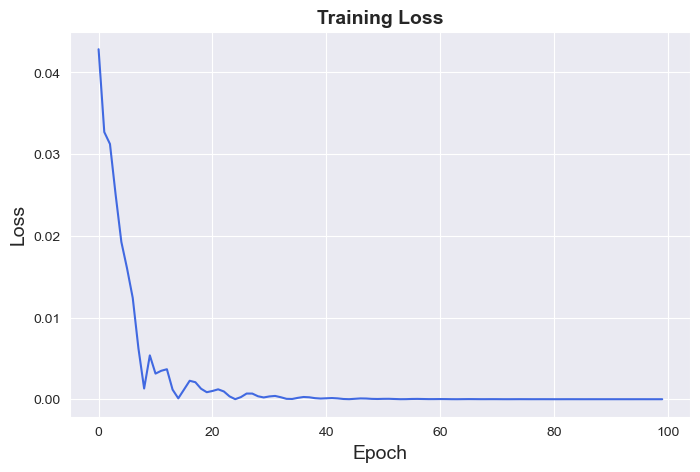

In [47]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam

hidden_dim = int(best_gru_model['hidden_dim'])
num_layers = int(best_gru_model['num_layers'])
time_step = int(best_gru_model['time_step'])

torch.manual_seed(42)
tune_gru = GRU_model(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
tune_gru = to_device(tune_gru, device)

evaluate_single_model(tune_gru, num_epochs, lr, loss_type, optimiser, time_step)

## Test Final Model

Epoch  0 MSE:  0.09753220528364182
Epoch  1 MSE:  0.045439865440130234
Epoch  2 MSE:  0.05725377798080444
Epoch  3 MSE:  0.05065715312957764
Epoch  4 MSE:  0.041713666170835495
Epoch  5 MSE:  0.038108691573143005
Epoch  6 MSE:  0.037308428436517715
Epoch  7 MSE:  0.03632259741425514
Epoch  8 MSE:  0.033460088074207306
Epoch  9 MSE:  0.02942574955523014
Epoch  10 MSE:  0.02554478868842125
Epoch  11 MSE:  0.023359300568699837
Epoch  12 MSE:  0.02138330787420273
Epoch  13 MSE:  0.013197357766330242
Epoch  14 MSE:  0.0068166968412697315
Epoch  15 MSE:  0.003802439197897911
Epoch  16 MSE:  0.0014066006988286972
Epoch  17 MSE:  0.0034302102867513895
Epoch  18 MSE:  0.005794005002826452
Epoch  19 MSE:  0.003911020699888468
Epoch  20 MSE:  0.0050425343215465546
Epoch  21 MSE:  0.004476758185774088
Epoch  22 MSE:  0.002021227264776826
Epoch  23 MSE:  0.0010002510389313102
Epoch  24 MSE:  0.0018644134979695082
Epoch  25 MSE:  0.0016121662920340896
Epoch  26 MSE:  0.0009011440561152995
Epoch  27 

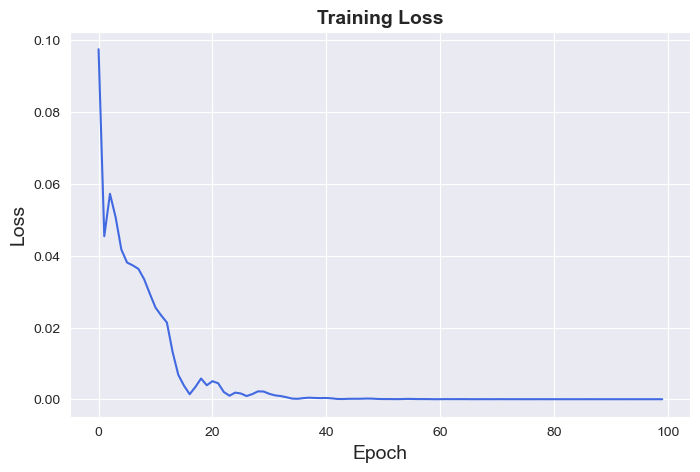

In [53]:
input_dim = 1
output_dim = 1
num_epochs = 100
lr = 0.01
loss_type = torch.nn.MSELoss(reduction = 'mean')
optimiser = torch.optim.Adam

hidden_dim = int(best_rnn_model['hidden_dim'])
num_layers = int(best_rnn_model['num_layers'])
time_step = int(best_rnn_model['time_step'])

torch.manual_seed(42)
final_model = RNN_relu(input_dim = input_dim, hidden_dim = hidden_dim, output_dim = output_dim, layer_dim = num_layers)
final_model = to_device(final_model, device)

test_final_model(final_model, num_epochs, lr, loss_type, optimiser, time_step)